# 0. Imports and installations

In [ ]:
!pip install arch
!pip install -U -q PyDrive
!pip install pymanopt
!pip install seaborn
!pip install statsmodels --upgrade
!pip install sklearn --upgrade
!pip install pywavelets

     |████████████████████████████████| 808kB 4.9MB/s 
     |████████████████████████████████| 61kB 3.4MB/s 
     |████████████████████████████████| 9.5MB 6.1MB/s 
  Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2
Requirement already up-to-date: sklearn in /usr/local/lib/python3.7/dist-packages (0.0)


In [ ]:
from arch.univariate import ConstantMean, GARCH, Normal
from arch import arch_model
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pandas_datareader.data as web
import pywt
import seaborn as sns

from pandas.tseries.offsets import CustomBusinessDay, DateOffset, WeekOfMonth
from pandas.tseries.holiday import sunday_to_monday, AbstractHolidayCalendar, Holiday, USMemorialDay, USLaborDay, USColumbusDay, USThanksgivingDay
from sklearn import metrics
from sklearn.model_selection import TimeSeriesSplit
from sklearn.utils.testing import ignore_warnings
from sklearn.exceptions import ConvergenceWarning
import scipy.stats as scs
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf, q_stat, adfuller
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import statsmodels.tsa.ar_model
import warnings

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.utils.testing module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.utils. Anything that cannot be imported from sklearn.utils is now part of the private API.
  warnings.warn(message, FutureWarning)


In [ ]:
warnings.filterwarnings('ignore')

In [ ]:
sns.set(rc={'figure.figsize':(20, 7)})

# I. Study of the data

## 1. Data processing

In [ ]:
# Code to read csv file into Colaboratory:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
# Authenticate and create the PyDrive client
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
# Load dataset from google drive
id = '1ATmaZrLwm1_hE1I1p7s2S1rjpLXv1ozx'
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('dataset.xlsx')  

df_BcBalance = pd.read_excel("dataset.xlsx", sheet_name = 'Bilan BC')
df_BcBalance.set_index('Date', inplace = True, drop = True)
df_BcBalance = df_BcBalance.resample('D').fillna(method = 'ffill')

df_daily_data = pd.read_excel("dataset.xlsx", sheet_name = 'Données journalières')
df_daily_data.set_index('Date', inplace = True, drop = True)
del df_daily_data['CRB - Bétail']

df_EconomicalSurprise = pd.read_excel("dataset.xlsx", sheet_name = 'Surprise économique')
df_EconomicalSurprise.set_index('Date', inplace = True, drop = True)
df_EconomicalSurprise = df_EconomicalSurprise.resample('D').fillna(method = 'ffill')

df_FedBalance = pd.read_excel("dataset.xlsx", sheet_name = 'Bilan FED')
df_FedBalance.set_index('Date', inplace = True, drop = True)
df_FedBalance = df_FedBalance.resample('D').fillna(method = 'ffill')

df_gold = pd.read_excel("dataset.xlsx", sheet_name = 'Or')
df_gold.set_index('Date', inplace = True, drop = True)
df_gold = df_gold.resample('D').fillna(method = 'ffill')

df_InflationUnemployment = pd.read_excel("dataset.xlsx", sheet_name = 'Chômage & Inflation')
df_InflationUnemployment.set_index('Date', inplace = True, drop = True)
df_InflationUnemployment = df_InflationUnemployment.resample('D').fillna(method = 'ffill')

df_oil = pd.read_excel("dataset.xlsx", sheet_name = 'Pétrole')
df_oil.set_index('Date', inplace = True, drop = True)
df_oil = df_oil.resample('D').fillna(method = 'ffill')

df_ProductionCapacity = pd.read_excel("dataset.xlsx", sheet_name = 'Capacité de production')
df_ProductionCapacity.set_index('Date', inplace = True, drop = True)
df_ProductionCapacity = df_ProductionCapacity.resample('D').fillna(method = 'ffill')

df_daily_data = df_daily_data.join(df_BcBalance).join(df_EconomicalSurprise).join(df_gold).join(df_InflationUnemployment).join(df_ProductionCapacity)
df_daily_data = df_daily_data[(df_daily_data.index >= '2000-12-31') & (df_daily_data.index <= '2019-12-31')]

In [ ]:
class BankCalendar(AbstractHolidayCalendar):
    rules = [
        Holiday("New Year's Day", month=1, day=1, observance=sunday_to_monday),
        Holiday("Martin Luther King Jr.'s Birthday", month=1, day=1, offset=WeekOfMonth(week=3, weekday=1)),
        Holiday("Washington's Birthday", month=2, day=1, offset=WeekOfMonth(week=3, weekday=1)),
        USMemorialDay,
        Holiday("Independence Day", month=7, day=4, observance=sunday_to_monday),
        USLaborDay,
        USColumbusDay,
        Holiday("Veteran's Day", month=11, day=11, observance=sunday_to_monday),
        USThanksgivingDay,
        Holiday("Christmas Day", month=12, day=25, observance=sunday_to_monday),
    ]

In [ ]:
# Keep only bank business days
Bank_business_days = CustomBusinessDay(calendar = BankCalendar())
business_days = pd.date_range('2000-12-31', end = '2019-12-31', freq = Bank_business_days)
df_business_days = pd.DataFrame(business_days, columns = ['Date'])
df_business_days.set_index('Date', inplace = True, drop = True)
df_daily_data = df_daily_data.join(df_business_days, how = 'right')

# Display the dataframe
df_daily_data

,SPX Index,Vix Index,GDP US,Taux 10 ans US,FDTR Index,Indice CRB,CRB - Métaux,CRB - Industrie de base,CRB - Alimentaire,CRB - Textile,MACD,BSPGCPUS Index,Surprise économique,Or,Chômage US,Confiance des consommateurs US,Inflation US,CPTICHNG Index
Date,,,,,,,,,,,,,,,,,,
2001-01-02,-2.80,29.99,3.0,4.9150,6.50,222.54,211.24,253.76,183.96,244.15,-15.078643,5.7,-0.218,270.0,3.9,128.55,3.4,79.9609
2001-01-03,5.01,26.60,3.0,5.1580,6.00,222.53,210.76,253.53,184.17,244.15,-11.375763,5.7,-0.218,269.3,3.9,128.55,3.4,79.9609
2001-01-04,-1.06,26.97,3.0,5.0390,6.00,222.80,210.62,253.95,184.29,243.49,-9.479367,5.7,-0.218,268.4,3.9,128.55,3.4,79.9609
2001-01-05,-2.62,28.67,3.0,4.9310,6.00,223.70,210.83,254.36,185.68,243.43,-10.676785,5.7,-0.218,269.0,3.9,128.55,3.4,79.9609
2001-01-08,-0.19,29.84,3.0,4.9560,6.00,224.48,211.59,255.17,186.40,244.80,-11.691893,5.7,-0.218,269.0,3.9,128.55,3.4,79.9609
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-24,-0.02,12.67,2.1,1.8996,1.75,398.81,757.07,451.23,333.39,280.42,34.643269,18.8,0.138,1499.1,3.5,126.80,2.1,77.5723
2019-12-26,0.51,12.65,2.1,1.8944,1.75,399.49,758.45,451.60,334.39,280.52,36.152876,18.8,0.138,1509.3,3.5,126.80,2.1,77.5723
2019-12-27,0.00,13.43,2.1,1.8752,1.75,401.00,758.15,451.65,337.44,280.76,36.932393,18.8,0.138,1513.8,3.5,126.80,2.1,77.5723


In [ ]:
df_SPX = pd.DataFrame(df_daily_data['SPX Index'].copy())
df_SPX.index = df_daily_data.index.copy()
del df_daily_data['SPX Index']

df_Vix = pd.DataFrame(df_daily_data['Vix Index'].copy())
df_Vix.index = df_daily_data.index.copy()
del df_daily_data['Vix Index']

## 2. Data analysis

### 2.1. White noises and random walks

#### a. White noise

White noise indicators :
Mean: 0.010
Variance: 0.998
Standard deviation: 0.999


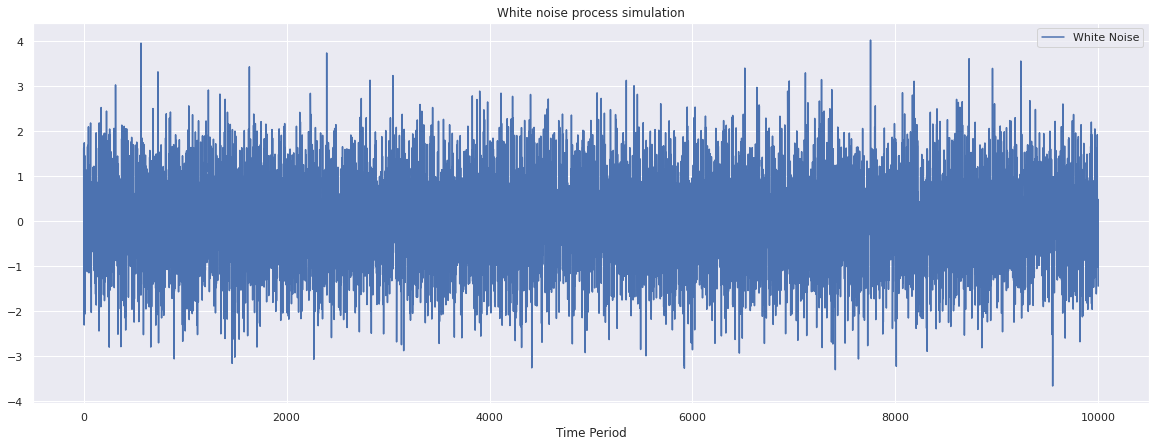

In [ ]:
# Simulate and display a white noise process
np.random.seed(1)
n_sample = 10000
df_white_noise = pd.DataFrame(data = np.random.normal(size = n_sample), columns = ['White Noise'])
fig = sns.lineplot(data = df_white_noise)
fig.set(xlabel = 'Time Period', title = 'White noise process simulation')
print("White noise indicators :\nMean: {:.3f}\nVariance: {:.3f}\nStandard deviation: {:.3f}".format(df_white_noise['White Noise'].mean(), df_white_noise['White Noise'].var(), df_white_noise['White Noise'].std()))

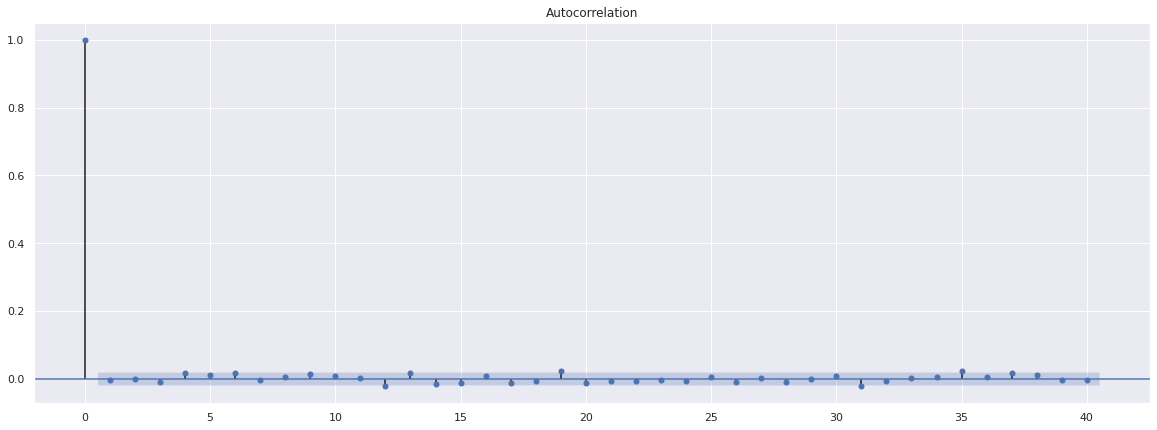

In [ ]:
# Display the autocorrelation of our white noise
ploted_white_noise_autoc = plot_acf(df_white_noise['White Noise'])

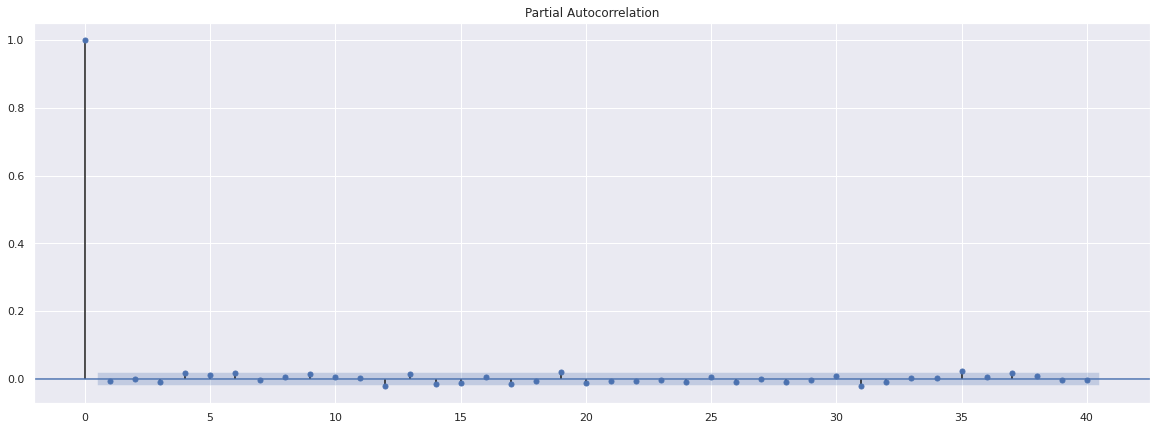

In [ ]:
# Display the partial autocorrelation of our white noise
ploted_white_noise_partial_autoc = plot_pacf(df_white_noise['White Noise'])

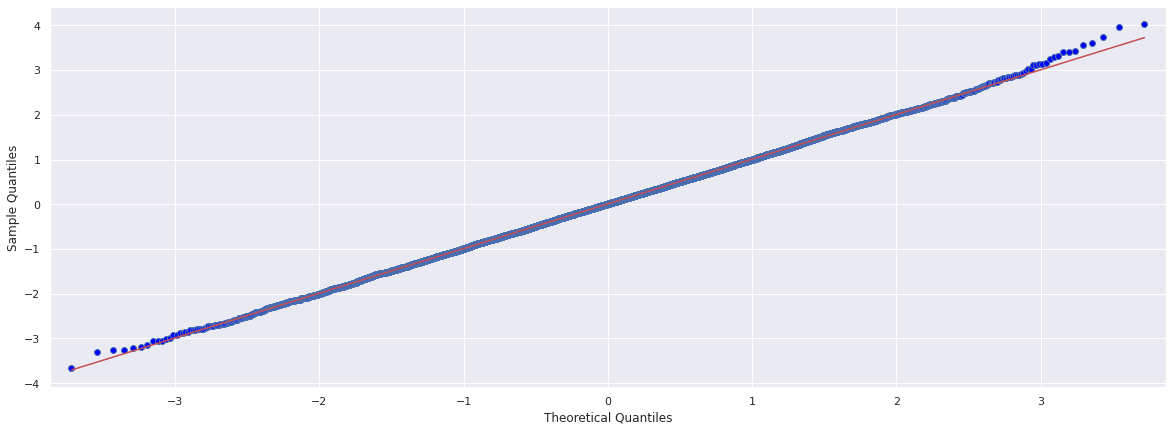

In [ ]:
# Display the Q-Q plot of our white noise against the standard normal distribution
ploted_white_noise_qq = sm.qqplot(df_white_noise['White Noise'], line='s')

#### b. Random walks

Random walk indicators' :
	Mean : 63.634
	Variance : 790.830
	Standard deviation : 28.122


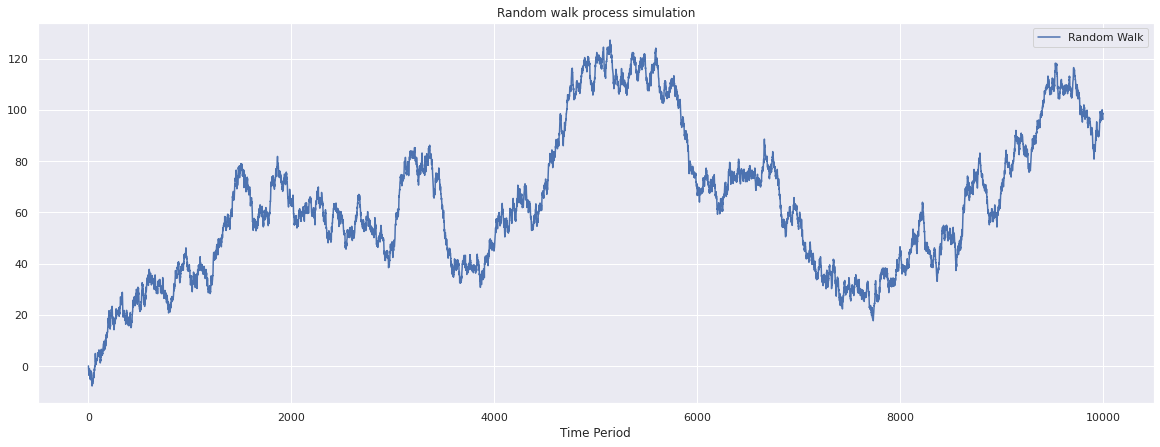

In [ ]:
# Simulate and display a random walk
np.random.seed(1)
n_sample = 10000

x = w = np.random.normal(size = n_sample)
for t in range(n_sample):
  x[t] = x[t-1] + w[t]

df_random_walk = pd.DataFrame(data = x, columns = ['Random Walk'])
fig = sns.lineplot(data = df_random_walk)
fig.set(xlabel = 'Time Period', title = 'Random walk process simulation')
print("Random walk indicators' :\n\tMean : {:.3f}\n\tVariance : {:.3f}\n\tStandard deviation : {:.3f}".format(df_random_walk['Random Walk'].mean(), df_random_walk['Random Walk'].var(), df_random_walk['Random Walk'].std()))

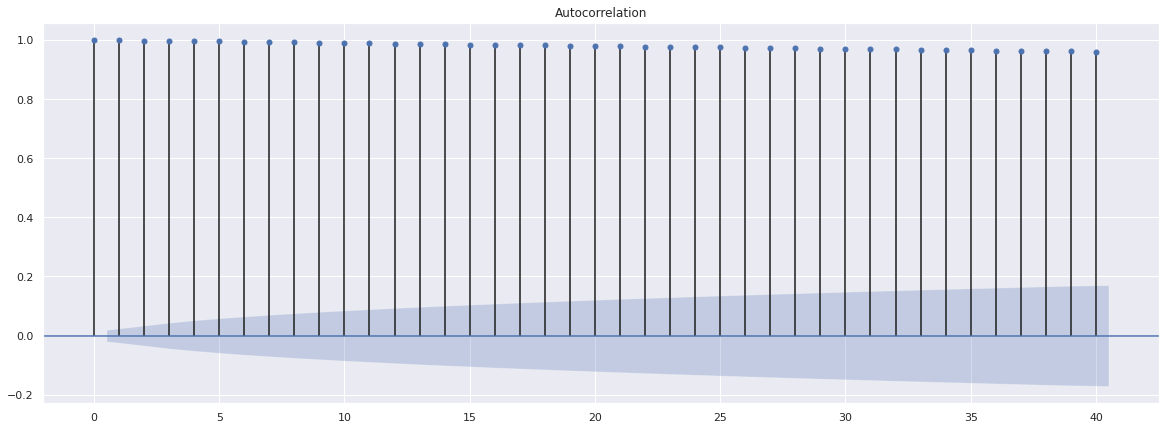

In [ ]:
# Display the autocorrelation of our white noise
ploted_random_walk_autoc = plot_acf(df_random_walk['Random Walk'])

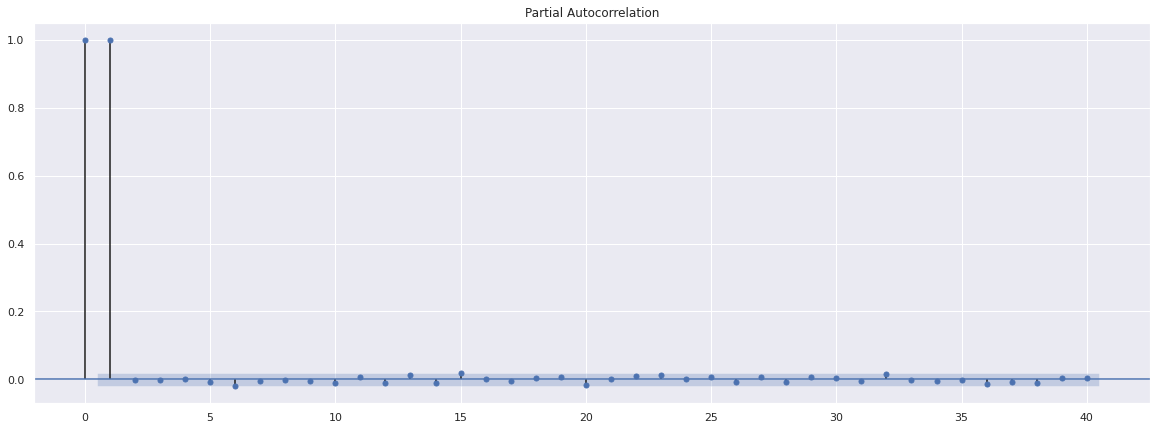

In [ ]:
# Display the partial autocorrelation of our white noise
ploted_random_walk_partial_autoc = plot_pacf(df_random_walk['Random Walk'])

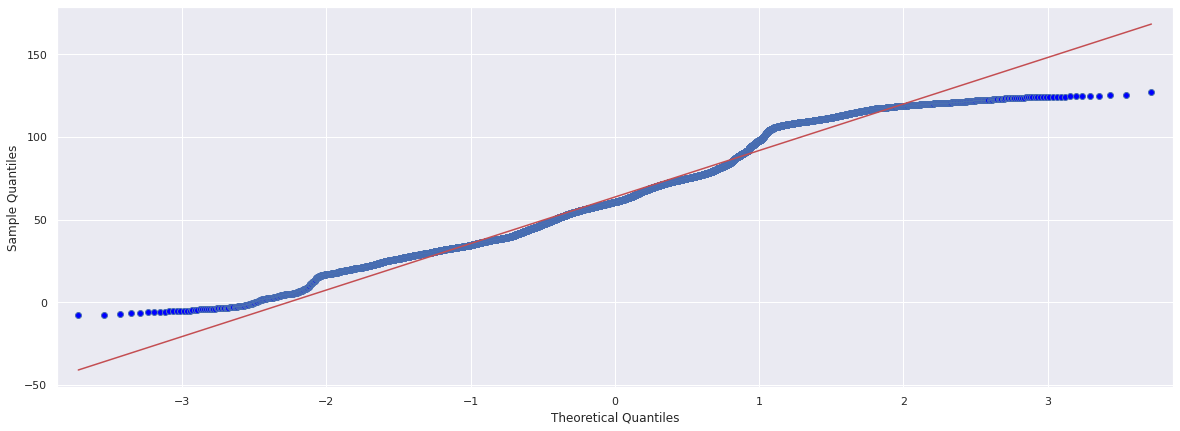

In [ ]:
# Display the Q-Q plot of our random walk against the standard normal distribution
ploted_SPX_qq = sm.qqplot(df_random_walk['Random Walk'], line='s')

### 2.2. SPX Index study

#### a. SPX Returns

SPX indicators' :
	Mean : 0.022
	Variance : 1.283
	Standard deviation : 1.133


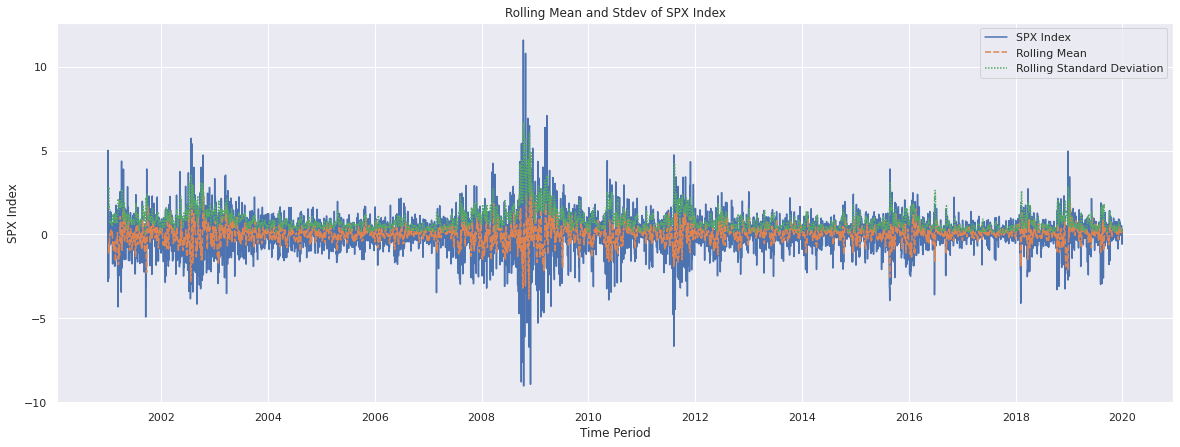

In [ ]:
window = 7
df_SPX['Rolling Mean'] = df_SPX['SPX Index'].rolling(window).mean()
df_SPX['Rolling Standard Deviation'] = df_SPX['SPX Index'].rolling(window).std()
fig = sns.lineplot(data = df_SPX)
fig.set(xlabel = 'Time Period', ylabel = 'SPX Index', title = 'Rolling Mean and Stdev of SPX Index')
print("SPX indicators' :\n\tMean : {:.3f}\n\tVariance : {:.3f}\n\tStandard deviation : {:.3f}".format(df_SPX['SPX Index'].mean(), df_SPX['SPX Index'].var(), df_SPX['SPX Index'].std()))

In [ ]:
# Test of Dickey-Fuller for SPX's stationnarity
adf_SPX = adfuller(df_SPX['SPX Index'])
 
print('ADF Statistics : {}'.format(adf_SPX[0]))
print('p-value : {}'.format(adf_SPX[1]))
print('Critical values :')
for key, value in adf_SPX[4].items():
    print('\t{} : {}'.format(key, value))

ADF Statistics : -15.438752259268984
p-value : 2.883700250748128e-28
Critical values :
	1% : -3.431296156998735
	5% : -2.8619581245615096
	10% : -2.566992563823708


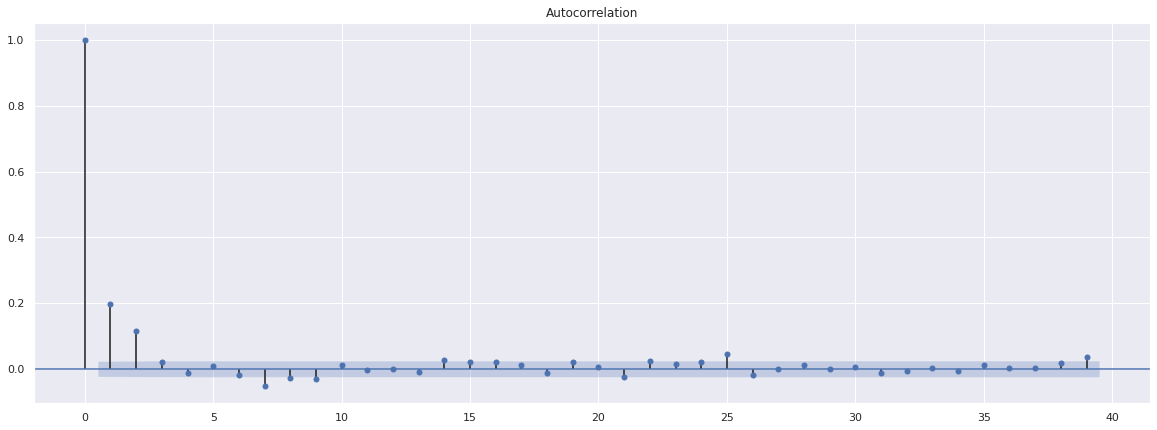

In [ ]:
# Display the autocorrelation of the SPX Index
ploted_SPX_autoc = plot_acf(df_SPX['SPX Index'])

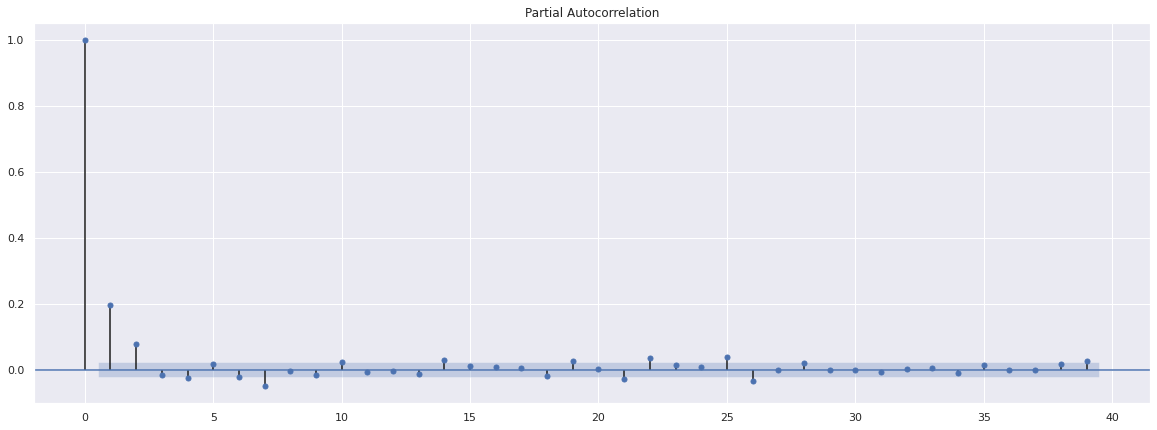

In [ ]:
# Display the partial autocorrelation of the SPX Index
ploted_SPX_partial_autoc = plot_pacf(df_SPX['SPX Index'])

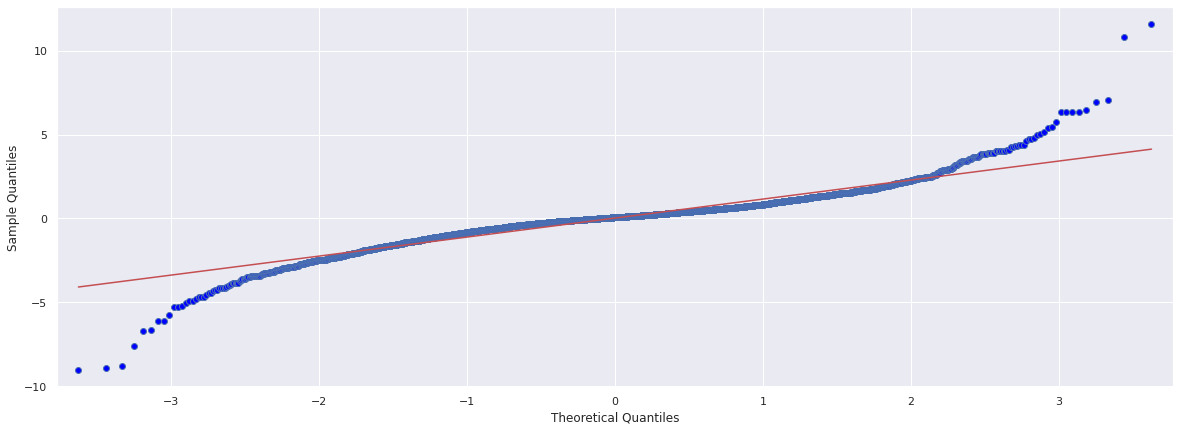

In [ ]:
# Display the Q-Q plot of the SPX Index against the standard normal distribution
ploted_SPX_qq = sm.qqplot(df_SPX['SPX Index'], line='s')

#### b. SPX closing price

SPX Closing Price indicators' :
Mean: 1515.290
Variance: 289300.053
Standard deviation: 537.866


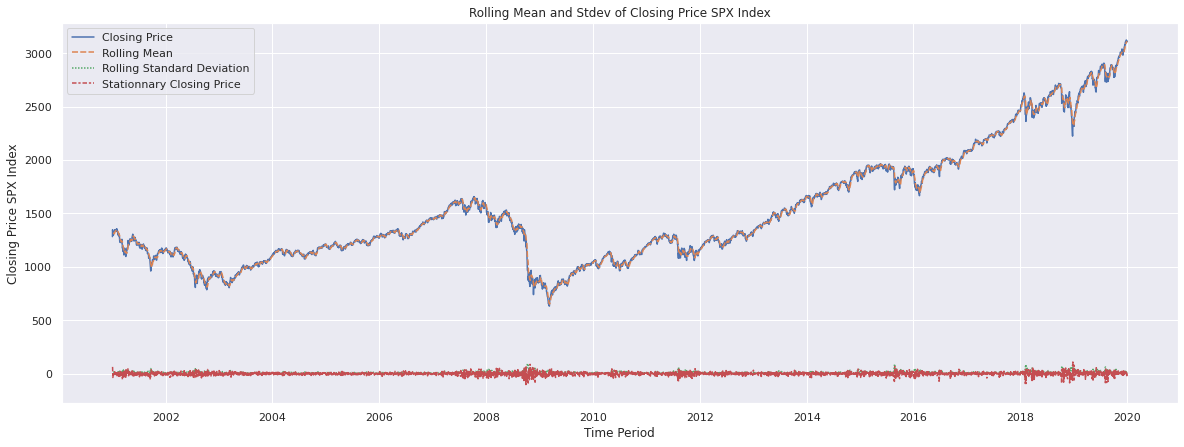

In [ ]:
rolling_window = 7
df_closing_price = pd.DataFrame(index = df_daily_data.index)
df_closing_price['Closing Price'] = 1320.28*(1 + df_SPX['SPX Index'].copy()/100).cumprod()
df_closing_price.index = df_daily_data.index.copy()
df_closing_price['Rolling Mean'] = df_closing_price['Closing Price'].copy().rolling(rolling_window).mean()
df_closing_price['Rolling Standard Deviation'] = df_closing_price['Closing Price'].copy().rolling(rolling_window).std()
df_closing_price['Stationnary Closing Price'] = pd.DataFrame(np.diff(df_closing_price['Closing Price'].copy()), index = df_daily_data.index[1:].copy())
fig = sns.lineplot(data = df_closing_price)
fig.set(xlabel = 'Time Period', ylabel = 'Closing Price SPX Index', title = 'Rolling Mean and Stdev of Closing Price SPX Index')
print("SPX Closing Price indicators' :\nMean: {:.3f}\nVariance: {:.3f}\nStandard deviation: {:.3f}".format(df_closing_price['Closing Price'].mean(), df_closing_price['Closing Price'].var(), df_closing_price['Closing Price'].std()))

In [ ]:
# Test of Dickey-Fuller for SPX closing price's stationnarity
adf_closing_price = adfuller(df_closing_price['Closing Price'])
 
print('ADF Statistics : {}'.format(adf_closing_price[0]))
print('p-value : {}'.format(adf_closing_price[1]))
print('Critical values :')
for key, value in adf_closing_price[4].items():
    print('\t{} : {}'.format(key, value))

ADF Statistics : 1.4293366137995243
p-value : 0.9972434223290522
Critical values :
	1% : -3.431293699246453
	5% : -2.86195703860701
	10% : -2.5669919857504557


In [ ]:
# Test of Dickey-Fuller for difference transformation SPX closing price's stationnarity
adf_log_closing_price = adfuller(df_closing_price['Stationnary Closing Price'].dropna())
 
print('ADF Statistics : {}'.format(adf_log_closing_price[0]))
print('p-value : {}'.format(adf_log_closing_price[1]))
print('Critical values :')
for key, value in adf_log_closing_price[4].items():
    print('\t{} : {}'.format(key, value))

ADF Statistics : -33.64608404662224
p-value : 0.0
Critical values :
	1% : -3.431293699246453
	5% : -2.86195703860701
	10% : -2.5669919857504557


# II. Trends modeling

In [ ]:
def trends_model_difference(df, trends_window):
  n = len(df)
  q, r = n // trends_window, n%trends_window
  trends = []
  for i in range(q):
    if df[(i+1)*trends_window - 1] - df[(i)*trends_window] > 0 :
      trends.append(1)
    else :
      trends.append(-1)
  if r != 0:
    if df[-1] - df[(q)*trends_window] > 0 :
      trends.append(1)
    else :
      trends.append(-1)
  if len(trends) == 1:
    return trends[0]
  else :
    return trends

In [ ]:
def trends_model_average(df, horizon, last_average):
  trends = []
  n = len(df)
  q, r = n // horizon, n%horizon
  for i in range(q):
    difference = df[i*horizon:(i+1)*horizon].mean() - last_average
    if difference > 0 :
      trends.append(1)
    else:
      trends.append(-1)
    last_average = df[i*horizon:(i+1)*horizon].mean() 
  if r != 0:
    difference = df[q*horizon:].mean() - df[(q-1)*horizon:q*horizon].mean()
    if difference > 0 :
      trends.append(1)
    else:
      trends.append(-1)      
  if len(trends) == 1:
    return trends[0]
  else :
    return trends

In [ ]:
def trends_forecast(best_p, best_q, best_o, df_predictor, df_target, df_target_volatility, n_test, n_train, trends_window):
  n_trends_window = n_test // trends_window
  predicted_trends_volatility = {'Average' : [], 'Difference' : []}
  last_window_mean = df_target_volatility[n_train - trends_window : n_train].mean()
  for i in range(n_trends_window + 1):
    model = arch_model(y = np.array(df_target[: n_train +  i * trends_window]), x = df_predictor[: n_train +  i * trends_window], vol = 'GARCH', p = best_p, o = best_o, q = best_q).fit(disp='off')
    predictions_closing_price = model.forecast(horizon = trends_window)
    model_forecast = model.forecast(horizon = trends_window)
    forecasted_volatility = np.sqrt(model_forecast.variance.values[-1,:])
    predicted_trends_volatility['Average'].append(trends_model_average(forecasted_volatility, trends_window, last_window_mean))
    predicted_trends_volatility['Difference'].append(trends_model_difference(forecasted_volatility, trends_window))
    last_window_mean = forecasted_volatility.mean()
  return predicted_trends_volatility

In [ ]:
def confusion_matrix(expected, predicted, nrm = None):
  df_confusion_matrix = pd.DataFrame(data = metrics.confusion_matrix(expected, predicted, normalize = nrm), columns = ['Actual Positive', 'Actual Negative'], index = ['Predicted Positive', 'Predicted Negative'])
  return df_confusion_matrix

In [ ]:
def true_positive(df_expected_trends, df_predicted_trends):
  return ((df_expected_trends > 0) * (df_predicted_trends > 0)) * 1

In [ ]:
def true_negative(df_expected_trends, df_predicted_trends):
  return sum(((df_expected_trends < 0) * (df_predicted_trends < 0)) * 1)

In [ ]:
def false_positive(df_expected_trends, df_predicted_trends):
  return sum(((df_expected_trends < 0) * (df_predicted_trends > 0)) * 1)

In [ ]:
def false_negative(df_expected_trends, df_predicted_trends):
  return (((df_expected_trends > 0) * (df_predicted_trends < 0)) * 1).sum()

In [ ]:
def true_positive_rate(df_expected_trends, df_predicted_trends):
  tp = true_positive(df_expected_trends, df_predicted_trends)
  fn = false_negative(df_expected_trends, df_predicted_trends)
  return (tp / (tp + fn))

In [ ]:
def false_positive_rate(df_expected_trends, df_predicted_trends):
  fp = false_positive(df_expected_trends, df_predicted_trends)
  tn = true_negative(df_expected_trends, df_predicted_trends)
  return (fp / tn + fp)

In [ ]:
def roc_bis(df_expected_trends, nb_thresholds):
  thresholds = np.linspace(1, 0 , num = nb_thresholds)
  expected_probabilities = predict_proba(df_expected)
  tpr, fpr = [0], [0]
  for threshold in thresholds :
    predictions = []
    for probability in expected_probabilities :
      if probability > threshold :
        predictions.append(1)
      else :
        predictions.append(-1)
    tn, fp, fn, tp = metrics.confusion_matrix(df_expected, predictions).ravel()
    tpr.append((tp / (tp + fn))), fpr.append(fp / (tn + fp))
  return fpr, tpr

In [ ]:
def roc(df_expected_trends, df_predicted_trends):
  return false_positive_rate(df_expected_trends, df_predicted_trends), true_positive_rate(df_expected_trends, df_predicted_trends)

In [ ]:
def auc(TFP, TVP):
  return ((TFP[1:].values - TFP[:-1].values)*(TVP[1:].values + TVP[:-1].values)/2).sum()

In [ ]:
def plot_confusion_matrix(df_confusion_matrix, model, trends_window):
  fig = sns.heatmap(df_confusion_matrix, annot = True, fmt = 'g' )
  fig.set_xlabel('Actual trends')
  fig.set_ylabel('Predicted trends')
  fig.set_title('Confusion Matrix ' + model + '-' + str(trends_window))
  fig.xaxis.set_ticklabels(['Positives', 'Negatives'])
  fig.yaxis.set_ticklabels(['Positives', 'Negatives'])

In [ ]:
def mean_absolute_percentage_error(expected, predicted):
  return np.mean(np.abs((expected - predicted)/expected))*100

def forecasting_performance_measures(expected, predicted):
  mae = metrics.mean_absolute_error(expected, predicted)
  mape = mean_absolute_percentage_error(expected, predicted)
  medae = metrics.median_absolute_error(expected, predicted)
  mse = metrics.mean_squared_error(expected, predicted)
  rmse = math.sqrt(mse)
  return pd.DataFrame({'MAE' : mae, 'MAPE' : mape, 'MEDAE' : medae, 'MSE' : mse, 'RMSE' : rmse}, index = ['GARCH'])

def metrics_classification_report(expected, predicted, trends_model):
  df_metrics_report = pd.DataFrame(columns = [trends_model], index = ['Accuracy', 'F1', 'Precision','Recall'])
  df_metrics_report[trends_model]['Accuracy'] = metrics.accuracy_score(expected, predicted)
  df_metrics_report[trends_model]['F1'] = metrics.f1_score(expected, predicted)
  df_metrics_report[trends_model]['Precision'] = metrics.precision_score(expected, predicted)
  df_metrics_report[trends_model]['Recall'] = metrics.recall_score(expected, predicted)
  return df_metrics_report

def mma(df, trends_window):
  return df.copy().rolling(trends_window).mean()

def mma_to_trends(df, trends_window):
  mma_computed = mma(df, trends_window)
  return (df > mma_computed)*1 + (df <= mma_computed)*(-1)

def mme(df, trends_window):
  return df.transform(lambda x: x.ewm(span = trends_window, adjust = False).mean())

def mme_to_trends(df, trends_window):
  mme_computed = mme(df, trends_window)
  return (df > mme_computed)*1 + (df <= mme_computed)*(-1)

def macd(df, trends_window_1, trends_window_2):
  if trends_window_1 < trends_window_2 :
    return mme(df, trends_window_2) - mme(df, trends_window_1)
  else :
    return mme(df, trends_window_1) - mme(df, trends_window_2)

def macd_to_trends(df, trends_window_1, trends_window_2, trends_window_3):
  difference = macd(df, trends_window_1, trends_window_2) - mme(df, trends_window_3)
  return (df > difference)*1 + (df <= difference)*(-1)


def trends_accuracy(predicted_trends, expected_trends):
  accuracy = 0
  for i in range(len(expected_trends)):
    if predicted_trends[i]*expected_trends[i] > 0:
      accuracy += 1
  accuracy /= len(expected_trends)  
  return accuracy*100

# III. Univariate time series modelling

## 1. GARCH model for Vix Index forecasting

### a. Motivations : link between S&P500 and Vix Index

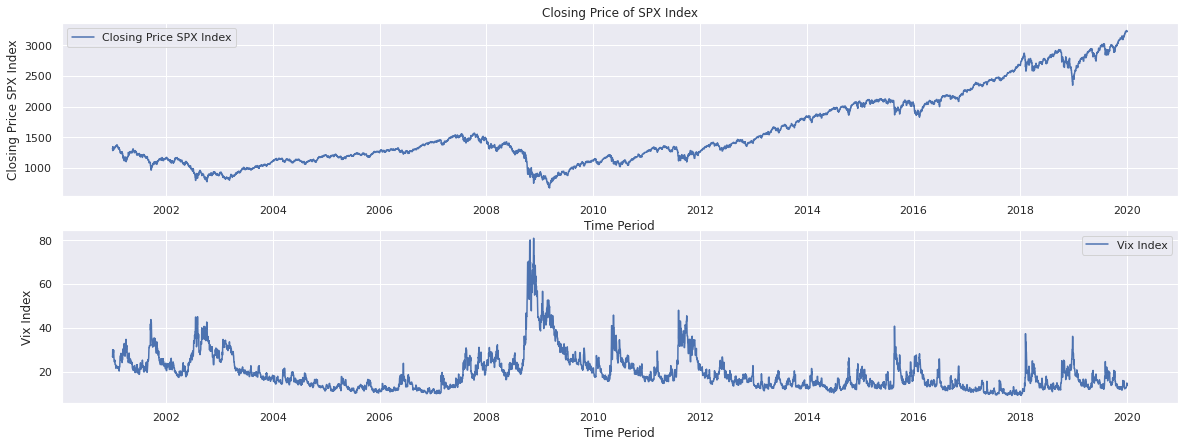

In [ ]:
# Display link between SPX and Vix indexes
df_SPX_Vix = pd.DataFrame(columns = ['Closing Price', 'Vix Index'], index = df_SPX.index)
df_SPX_Vix['Closing Price'] = df_closing_price['Closing Price'].copy()
df_SPX_Vix['Vix Index'] = df_Vix['Vix Index'].copy()
fig, axes = plt.subplots(2,1)
sns.lineplot(x = df_SPX_Vix.index, y = df_SPX_Vix['Closing Price'], ax = axes[0], legend = 'auto')
axes[0].set(xlabel = 'Time Period', ylabel = 'Closing Price SPX Index', title = 'Closing Price of SPX Index')
axes[0].legend(labels = ['Closing Price SPX Index'])
sns.lineplot(x = df_SPX_Vix.index, y = df_SPX_Vix['Vix Index'], ax = axes[1], legend = 'auto')
axes[1].set(xlabel = 'Time Period', ylabel = 'Vix Index')
axes[1].legend(labels = ['Vix Index'])

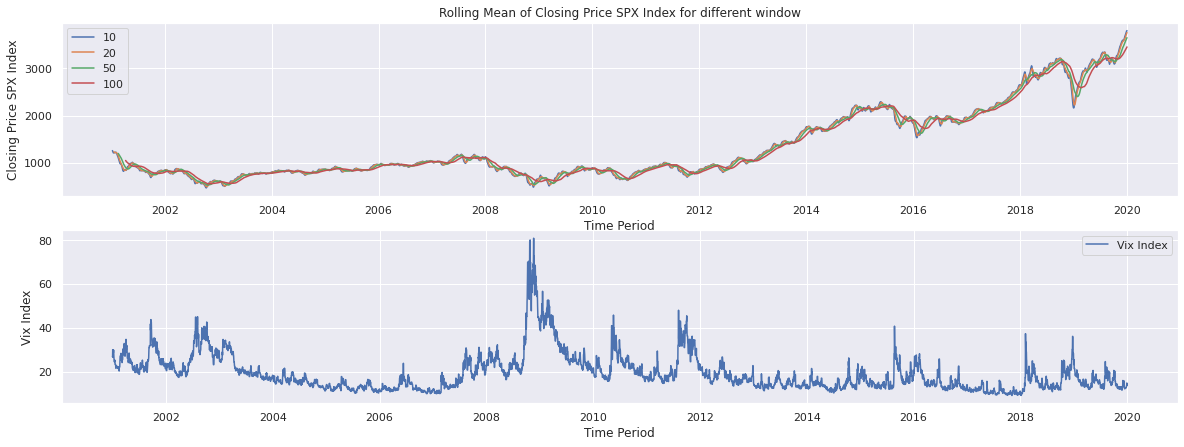

In [ ]:
# Display Vix Index and Closing Price SPX Index rolling mean for different windows
windows = [10, 20, 50, 100]
fig, axes = plt.subplots(2,1)
for window in windows :
  df_SPX_Vix['Rolling Mean ' + str(window)] = df_SPX_Vix['Closing Price'].rolling(int(window)).mean()
  sns.lineplot(x = df_SPX_Vix.index, y = df_SPX_Vix['Rolling Mean ' + str(window)], ax = axes[0], legend = 'auto')
axes[0].set(xlabel = 'Time Period', ylabel = 'Closing Price SPX Index', title = 'Rolling Mean of Closing Price SPX Index for different window')
axes[0].legend(labels = ['10', '20', '50', '100'])
sns.lineplot(x = df_SPX_Vix.index, y = df_SPX_Vix['Vix Index'], ax = axes[1], legend = 'auto')
axes[1].set(xlabel = 'Time Period', ylabel = 'Vix Index')
axes[1].legend(labels = ['Vix Index'])

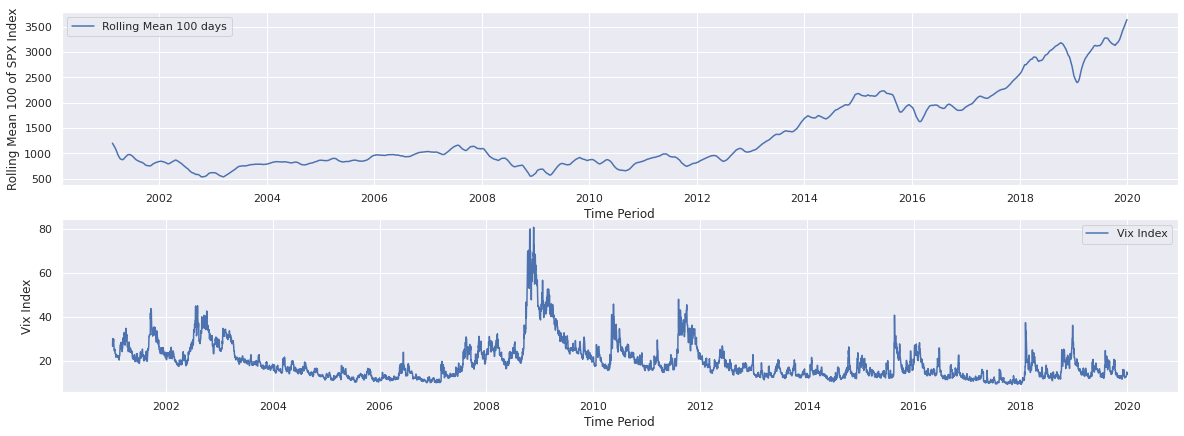

In [ ]:
fig, axes = plt.subplots(2,1)
window = 100
sns.lineplot(x = df_SPX_Vix.index, y = df_SPX_Vix['Rolling Mean ' + str(50)], ax = axes[0], legend = 'auto')
axes[0].set(xlabel = 'Time Period', ylabel = 'Rolling Mean ' + str(window) + ' of SPX Index')
axes[0].legend(labels = ['Rolling Mean ' + str(window) + ' days'])
sns.lineplot(x = df_SPX_Vix.index, y = df_SPX_Vix['Vix Index'], ax = axes[1], legend = 'auto')
axes[1].set(xlabel = 'Time Period', ylabel = 'Vix Index')
axes[1].legend(labels = ['Vix Index'])

### b. A first naive attempt

#### i. Some useful functions

In [ ]:
@ignore_warnings(category = ConvergenceWarning)
def get_best_model(df_y_train, df_x_train, r = False):
  best_aic = np.inf
  best_order = None
  best_model = None
  for i in range(10) :
    for j in range(1,10) :
      for k in range(10) :
        tmp_model = arch_model(y = np.array(df_y_train), x = df_x_train, vol = 'GARCH', p = i, o = j, q = k, rescale = r).fit(disp = 'off')
        tmp_aic = tmp_model.aic
        if tmp_aic < best_aic :
          best_aic = tmp_aic
          best_order = (i, j, k)
          best_model = tmp_model
  print('AIC of best model : {:6.5f} | Order of best model : {}'.format(best_aic, best_order))
  return best_aic, best_order, best_model

#### ii. The study with S&P500 returns

In [ ]:
 # Train/test split of our data
n_train = int(0.8*len(df_dailyData))
n_test = len(df_dailyData) - n_train
df_dailyData_train, df_dailyData_test = df_dailyData.iloc[:n_train,:], df_dailyData.iloc[n_train:,:]
df_SPX_train, df_SPX_test = df_SPX.iloc[:n_train,:], df_SPX.iloc[n_train:,:]
df_Vix_train, df_Vix_test = df_Vix.iloc[:n_train,:], df_Vix.iloc[n_train:,:]

In [ ]:
best_aic, best_order, best_model = getBestModel(df_SPX_train['SPX Index'], df_dailyData_train)

/usr/local/lib/python3.6/dist-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,
/usr/local/lib/python3.6/dist-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,
/usr/local/lib/python3.6/dist-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,
/usr/local/lib/python3.6/dist-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  Converge

AIC of best model : 14899.45555 | Order of best model : (1, 6, 8)


In [ ]:
best_p, best_o, best_q = best_order[0], best_order[1], best_order[2]
print(best_model.summary())

                   Constant Mean - GJR-GARCH Model Results                    
Dep. Variable:                      y   R-squared:                      -0.000
Mean Model:             Constant Mean   Adj. R-squared:                 -0.000
Vol Model:                  GJR-GARCH   Log-Likelihood:               -7432.73
Distribution:                  Normal   AIC:                           14899.5
Method:            Maximum Likelihood   BIC:                           15012.0
                                        No. Observations:                 5552
Date:                Fri, Jan 22 2021   Df Residuals:                     5535
Time:                        09:23:14   Df Model:                           17
                                 Mean Model                                 
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu             0.0403  1.197e-02      3.363  7.707e-04 [1.

[Text(0, 0.5, 'Residuals'),
 Text(0.5, 0, 'Time Period'),
 Text(0.5, 1.0, 'Standard Residuals')]

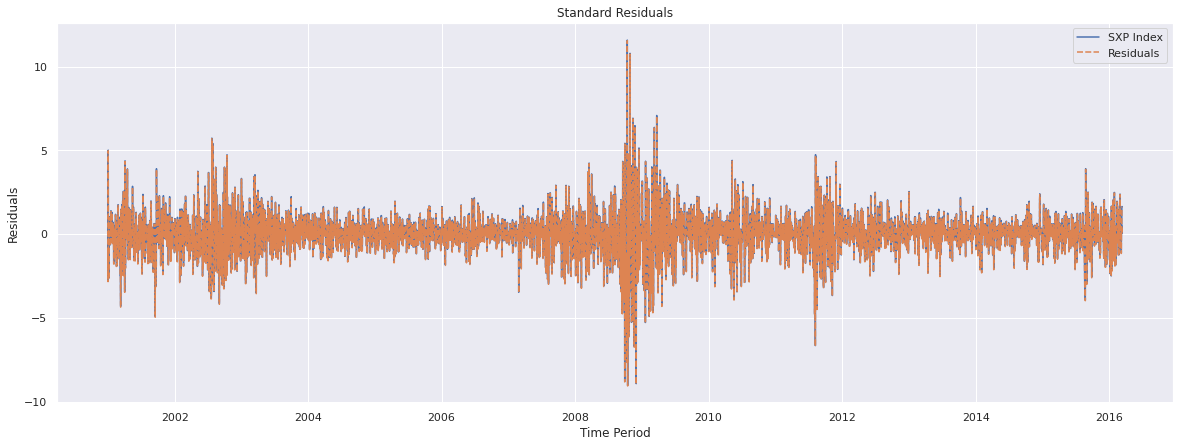

In [ ]:
df_residuals = pd.DataFrame(columns = ['SXP Index', 'Residuals'], index = df_dailyData_train.index)
df_residuals['SXP Index'] = df_SPX_train['SPX Index']
df_residuals['Residuals'] = best_model.resid
fig = sns.lineplot(data = df_residuals)
fig.set(xlabel = 'Time Period', ylabel = 'Residuals', title = 'Standard Residuals')

[Text(0, 0.5, 'Volatility'),
 Text(0.5, 0, 'Time Period'),
 Text(0.5, 1.0, 'Volatility of S&P500 computed using univariate GARCH')]

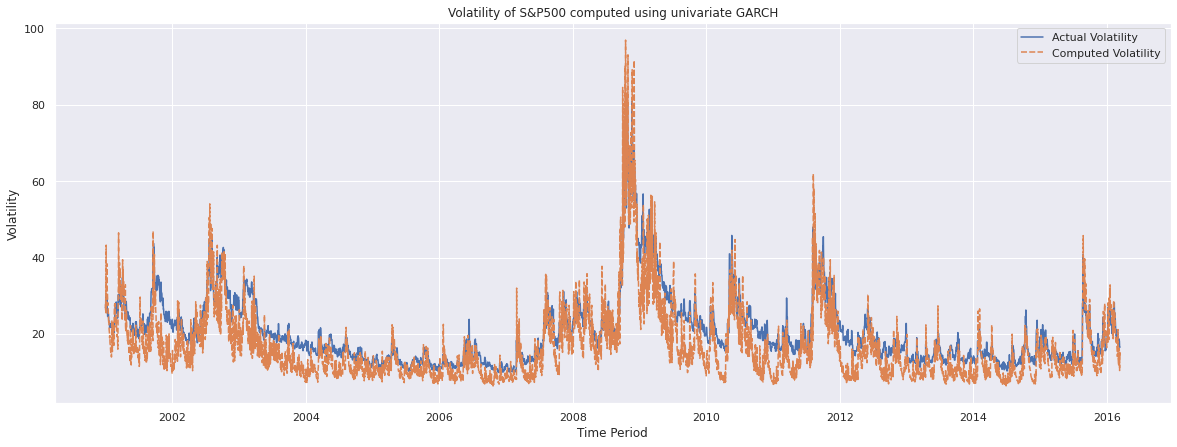

In [ ]:
conditionnalVolatility = math.sqrt(252) * best_model.conditional_volatility
df_volatility_train = pd.DataFrame(columns = ['Actual Volatility', 'Computed Volatility'], index = df_dailyData_train.index)
df_volatility_train['Actual Volatility'] = df_Vix['Vix Index']
df_volatility_train['Computed Volatility'] = conditionnalVolatility
fig = sns.lineplot(data = df_volatility_train)
fig.set(xlabel = 'Time Period', ylabel = 'Volatility', title = 'Volatility of S&P500 computed using univariate GARCH')

In [ ]:
n_days = 15
forecast = best_model.forecast(horizon = n_days, start = df_dailyData_test.index)
forecast.variance.tail()

,h.01,h.02,h.03,h.04,h.05,h.06,h.07,h.08,h.09,h.10,h.11,h.12,h.13,h.14,h.15
5547,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5548,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5549,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5550,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5551,0.925564,0.717704,0.762349,0.679543,0.728783,0.718619,0.832517,0.802654,0.806845,0.763342,0.765559,0.755158,0.788886,0.801044,0.818154


In [ ]:
df_volatility_test = pd.DataFrame(columns = ['Actual Volatility', 'Predicted Volatility'], index = df_dailyData_test.index[0 : n_days])
df_volatility_test['Actual Volatility'] = df_Vix_test['Vix Index'][0 : n_days]
df_volatility_test['Predicted Volatility'] = math.sqrt(252) * np.sqrt(forecast.variance.values[-1,:])

In [ ]:
df_volatility_test_mma = pd.DataFrame(columns = ['Actual Volatility', 'Predicted Volatility'], index = df_dailyData_test.index[0 : n_days])
trends_window_1_mma = 3
trends_window_2_mma = 5
df_volatility_test_mma['Actual Volatility'] = df_Vix_test['Vix Index'][0 : n_days]
df_volatility_test_mma['Predicted Volatility'] = math.sqrt(252) * np.sqrt(forecast.variance.values[-1,:])
df_volatility_test_mma['MMA-' + str(trends_window_1_mma) + ' Actual Volatility'] = pd.DataFrame(data = mma(df_volatility_test_mma['Actual Volatility'].copy(), trends_window_1_mma), index = df_dailyData_test.index[0 : n_days])
df_volatility_test_mma['MMA-' + str(trends_window_2_mma) + ' Actual Volatility'] = pd.DataFrame(data = mma(df_volatility_test_mma['Actual Volatility'].copy(), trends_window_2_mma), index = df_dailyData_test.index[0 : n_days])
df_volatility_test_mma['MMA-' + str(trends_window_1_mma) + ' Predicted Volatility'] = pd.DataFrame(data = mma(df_volatility_test_mma['Predicted Volatility'].copy(), trends_window_1_mma), index = df_dailyData_test.index[0 : n_days])
df_volatility_test_mma['MMA-' + str(trends_window_2_mma) + ' Predicted Volatility'] = pd.DataFrame(data = mma(df_volatility_test_mma['Predicted Volatility'].copy(), trends_window_2_mma), index = df_dailyData_test.index[0 : n_days])
df_volatility_test_mma['MMA-' + str(trends_window_1_mma) + ' Actual Volatility Trends'] = pd.DataFrame(data = mma_to_trends(df_volatility_test_mma['Actual Volatility'].copy(), trends_window_1_mma), index = df_dailyData_test.index[0 : n_days])
df_volatility_test_mma['MMA-' + str(trends_window_2_mma) + ' Actual Volatility Trends'] = pd.DataFrame(data = mma_to_trends(df_volatility_test_mma['Actual Volatility'].copy(), trends_window_2_mma), index = df_dailyData_test.index[0 : n_days])
df_volatility_test_mma['MMA-' + str(trends_window_1_mma) + ' Predicted Volatility Trends'] = pd.DataFrame(data = mma_to_trends(df_volatility_test_mma['Predicted Volatility'].copy(), trends_window_1_mma), index = df_dailyData_test.index[0 : n_days])
df_volatility_test_mma['MMA-' + str(trends_window_2_mma) + ' Predicted Volatility Trends'] = pd.DataFrame(data = mma_to_trends(df_volatility_test_mma['Predicted Volatility'].copy(), trends_window_2_mma), index = df_dailyData_test.index[0 : n_days])

[Text(0, 0.5, 'Volatility'), Text(0.5, 0, 'Time Period')]

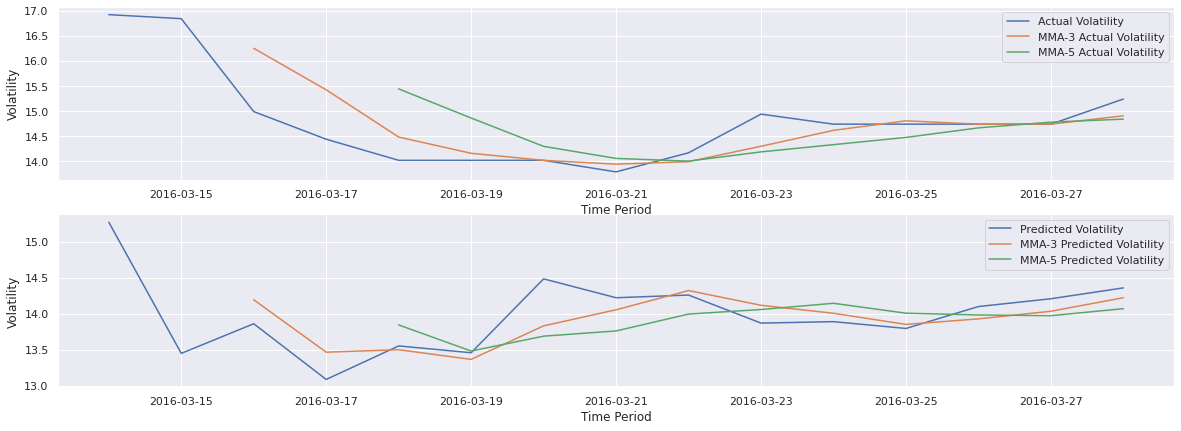

In [ ]:
fig, axes = plt.subplots(2,1)
sns.lineplot(x = df_volatility_test_mma.index, y = df_volatility_test_mma['Actual Volatility'], ax = axes[0], legend = 'auto')
sns.lineplot(x = df_volatility_test_mma.index, y = df_volatility_test_mma['MMA-' + str(trends_window_1_mma) + ' Actual Volatility'], ax = axes[0], legend = 'auto')
sns.lineplot(x = df_volatility_test_mma.index, y = df_volatility_test_mma['MMA-' + str(trends_window_2_mma) + ' Actual Volatility'], ax = axes[0], legend = 'auto')
axes[0].legend(labels = ['Actual Volatility', 'MMA-' + str(trends_window_1_mma) + ' Actual Volatility', 'MMA-' + str(trends_window_2_mma) + ' Actual Volatility'])
axes[0].set(xlabel = 'Time Period', ylabel = 'Volatility')
sns.lineplot(x = df_volatility_test_mma.index, y = df_volatility_test_mma['Predicted Volatility'], ax = axes[1], legend = 'auto')
sns.lineplot(x = df_volatility_test_mma.index, y = df_volatility_test_mma['MMA-' + str(trends_window_1_mma) + ' Predicted Volatility'], ax = axes[1], legend = 'auto')
sns.lineplot(x = df_volatility_test_mma.index, y = df_volatility_test_mma['MMA-' + str(trends_window_2_mma) + ' Predicted Volatility'], ax = axes[1], legend = 'auto')
axes[1].legend(labels = ['Predicted Volatility', 'MMA-' + str(trends_window_1_mma) + ' Predicted Volatility', 'MMA-' + str(trends_window_2_mma) + ' Predicted Volatility'])
axes[1].set(xlabel = 'Time Period', ylabel = 'Volatility')

In [ ]:
accuracy_trends_window_1_mma = trends_accuracy(df_volatility_test_mma['MMA-' + str(trends_window_1_mma) + ' Predicted Volatility Trends'][trends_window_1_mma:], df_volatility_test_mma['MMA-' + str(trends_window_1_mma) + ' Actual Volatility Trends'][trends_window_1_mma:])
accuracy_trends_window_2_mma = trends_accuracy(df_volatility_test_mma['MMA-' + str(trends_window_2_mma) + ' Predicted Volatility Trends'][trends_window_2_mma:], df_volatility_test_mma['MMA-' + str(trends_window_2_mma) + ' Actual Volatility Trends'][trends_window_2_mma:])
df_accuracy_trends_mma = pd.DataFrame({'MMA-' + str(trends_window_1_mma) : accuracy_trends_window_1_mma, 'MMA-' + str(trends_window_2_mma) : accuracy_trends_window_2_mma}, index = ['Accuracy'])
df_accuracy_trends_mma

,MMA-3,MMA-5
Accuracy,25.0,40.0


In [ ]:
df_volatility_test_mme = pd.DataFrame(columns = ['Actual Volatility', 'Predicted Volatility'], index = df_dailyData_test.index[0 : n_days])
trends_window_1_mme = 3
trends_window_2_mme = 8
df_volatility_test_mme['Actual Volatility'] = df_Vix_test['Vix Index'][0 : n_days]
df_volatility_test_mme['Predicted Volatility'] = math.sqrt(252) * np.sqrt(forecast.variance.values[-1,:])
df_volatility_test_mme['MME-' + str(trends_window_1_mme) + ' Actual Volatility'] = pd.DataFrame(data = mme(df_volatility_test_mme['Actual Volatility'].copy(), trends_window_1_mme), index = df_dailyData_test.index[0 : n_days])
df_volatility_test_mme['MME-' + str(trends_window_2_mme) + ' Actual Volatility'] = pd.DataFrame(data = mme(df_volatility_test_mme['Actual Volatility'].copy(), trends_window_2_mme), index = df_dailyData_test.index[0 : n_days])
df_volatility_test_mme['MME-' + str(trends_window_1_mme) + ' Predicted Volatility'] = pd.DataFrame(data = mme(df_volatility_test_mme['Predicted Volatility'].copy(), trends_window_1_mme), index = df_dailyData_test.index[0 : n_days])
df_volatility_test_mme['MME-' + str(trends_window_2_mme) + ' Predicted Volatility'] = pd.DataFrame(data = mme(df_volatility_test_mme['Predicted Volatility'].copy(), trends_window_2_mme), index = df_dailyData_test.index[0 : n_days])
df_volatility_test_mme['MME-' + str(trends_window_1_mme) + ' Actual Volatility Trends'] = pd.DataFrame(data = mme_to_trends(df_volatility_test_mme['Actual Volatility'].copy(), trends_window_1_mme), index = df_dailyData_test.index[0 : n_days])
df_volatility_test_mme['MME-' + str(trends_window_2_mme) + ' Actual Volatility Trends'] = pd.DataFrame(data = mme_to_trends(df_volatility_test_mme['Actual Volatility'].copy(), trends_window_2_mme), index = df_dailyData_test.index[0 : n_days])
df_volatility_test_mme['MME-' + str(trends_window_1_mme) + ' Predicted Volatility Trends'] = pd.DataFrame(data = mme_to_trends(df_volatility_test_mme['Predicted Volatility'].copy(), trends_window_1_mme), index = df_dailyData_test.index[0 : n_days])
df_volatility_test_mme['MME-' + str(trends_window_2_mme) + ' Predicted Volatility Trends'] = pd.DataFrame(data = mme_to_trends(df_volatility_test_mme['Predicted Volatility'].copy(), trends_window_2_mme), index = df_dailyData_test.index[0 : n_days])

[Text(0, 0.5, 'Volatility'), Text(0.5, 0, 'Time Period')]

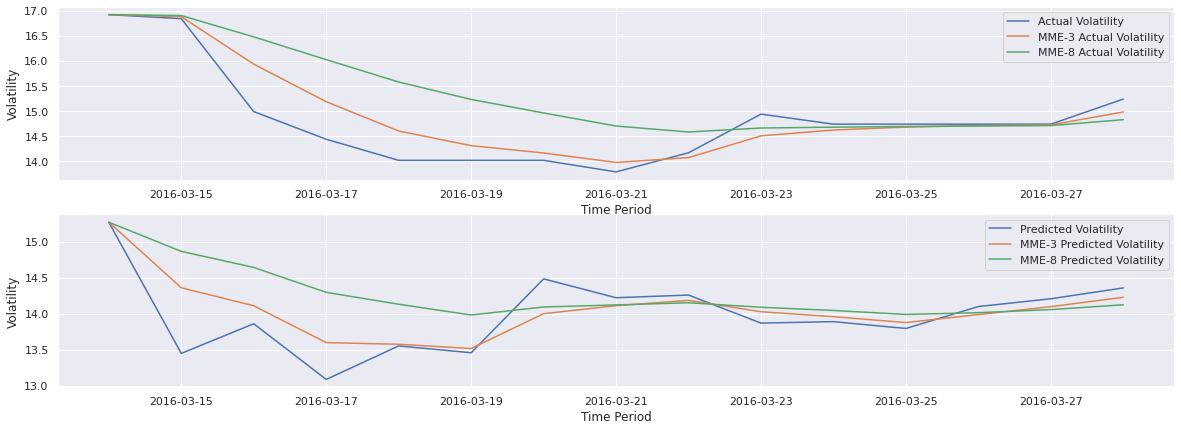

In [ ]:
fig, axes = plt.subplots(2,1)
sns.lineplot(x = df_volatility_test_mme.index, y = df_volatility_test_mme['Actual Volatility'], ax = axes[0], legend = 'auto')
sns.lineplot(x = df_volatility_test_mme.index, y = df_volatility_test_mme['MME-' + str(trends_window_1_mme) + ' Actual Volatility'], ax = axes[0], legend = 'auto')
sns.lineplot(x = df_volatility_test_mme.index, y = df_volatility_test_mme['MME-' + str(trends_window_2_mme) + ' Actual Volatility'], ax = axes[0], legend = 'auto')
axes[0].legend(labels = ['Actual Volatility', 'MME-' + str(trends_window_1_mme) + ' Actual Volatility', 'MME-' + str(trends_window_2_mme) + ' Actual Volatility'])
axes[0].set(xlabel = 'Time Period', ylabel = 'Volatility')
sns.lineplot(x = df_volatility_test_mme.index, y = df_volatility_test_mme['Predicted Volatility'], ax = axes[1], legend = 'auto')
sns.lineplot(x = df_volatility_test_mme.index, y = df_volatility_test_mme['MME-' + str(trends_window_1_mme) + ' Predicted Volatility'], ax = axes[1], legend = 'auto')
sns.lineplot(x = df_volatility_test_mme.index, y = df_volatility_test_mme['MME-' + str(trends_window_2_mme) + ' Predicted Volatility'], ax = axes[1], legend = 'auto')
axes[1].legend(labels = ['Predicted Volatility', 'MME-' + str(trends_window_1_mme) + ' Predicted Volatility', 'MME-' + str(trends_window_2_mme) + ' Predicted Volatility'])
axes[1].set(xlabel = 'Time Period', ylabel = 'Volatility')

In [ ]:
accuracy_trends_window_1_mme = trends_accuracy(df_volatility_test_mme['MME-' + str(trends_window_1_mme) + ' Predicted Volatility Trends'], df_volatility_test_mme['MME-' + str(trends_window_1_mme) + ' Actual Volatility Trends'])
accuracy_trends_window_2_mme = trends_accuracy(df_volatility_test_mme['MME-' + str(trends_window_2_mme) + ' Predicted Volatility Trends'], df_volatility_test_mme['MME-' + str(trends_window_2_mme) + ' Actual Volatility Trends'])
df_accuracy_trends_mme = pd.DataFrame({'MME-' + str(trends_window_1_mme) : accuracy_trends_window_1_mme, 'MME-' + str(trends_window_2_mme) : accuracy_trends_window_2_mme}, index = ['Accuracy'])
df_accuracy_trends_mme

,MME-3,MME-8
Accuracy,66.666667,60.0


In [ ]:
df_volatility_test_macd = pd.DataFrame(columns = ['Actual Volatility', 'Predicted Volatility'], index = df_dailyData_test.index[0 : n_days])
trends_window_1_macd = 5
trends_window_2_macd = 10
trends_window_3_macd = 2
df_volatility_test_macd['Actual Volatility'] = df_Vix_test['Vix Index'][0 : n_days]
df_volatility_test_macd['Predicted Volatility'] = math.sqrt(252) * np.sqrt(forecast.variance.values[-1,:])
df_volatility_test_macd['MACD-' + str(trends_window_1_macd) + '-' + str(trends_window_2_macd) + ' Actual Volatility'] = pd.DataFrame(data = macd(df_volatility_test['Actual Volatility'].copy(), trends_window_1_macd, trends_window_2_macd), index = df_dailyData_test.index[0 : n_days])
df_volatility_test_macd['MME-' + str(trends_window_3_macd) + ' Actual Volatility'] = pd.DataFrame(data = mme(df_volatility_test['Actual Volatility'].copy(), trends_window_3_macd), index = df_dailyData_test.index[0 : n_days])
df_volatility_test_macd['MACD-' + str(trends_window_1_macd) + '-' + str(trends_window_2_macd) + ' Predicted Volatility'] = pd.DataFrame(data = macd(df_volatility_test['Predicted Volatility'].copy(), trends_window_1_macd, trends_window_2_macd), index = df_dailyData_test.index[0 : n_days])
df_volatility_test_macd['MME-' + str(trends_window_3_macd) + ' Predicted Volatility'] = pd.DataFrame(data = mme(df_volatility_test['Predicted Volatility'].copy(), trends_window_3_macd), index = df_dailyData_test.index[0 : n_days])
df_volatility_test_macd['Trends Actual Volatility'] = pd.DataFrame(data = macd_to_trends(df_volatility_test_macd['Actual Volatility'], trends_window_1_macd, trends_window_2_macd, trends_window_3_macd), index = df_dailyData_test.index[0 : n_days])
df_volatility_test_macd['Trends Predicted Volatility'] = pd.DataFrame(data = macd_to_trends(df_volatility_test_macd['Predicted Volatility'], trends_window_1_macd, trends_window_2_macd, trends_window_3_macd), index = df_dailyData_test.index[0 : n_days])

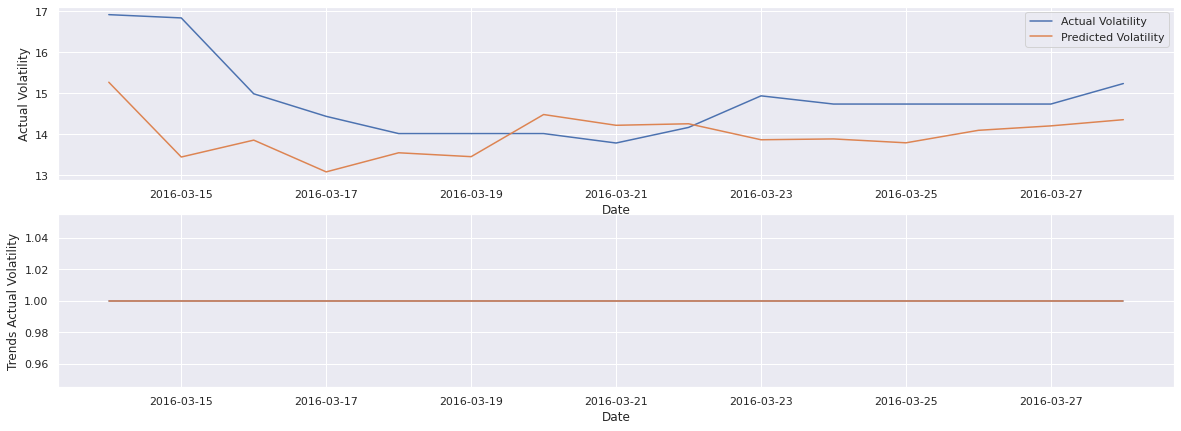

In [ ]:
fig, axes = plt.subplots(2,1)
sns.lineplot(x = df_volatility_test_macd.index, y = df_volatility_test_macd['Actual Volatility'], ax = axes[0], legend = 'auto')
sns.lineplot(x = df_volatility_test_macd.index, y = df_volatility_test_macd['Predicted Volatility'], ax = axes[0], legend = 'auto')
axes[0].legend(labels = ['Actual Volatility', 'Predicted Volatility'])
sns.lineplot(x = df_volatility_test_macd.index, y = df_volatility_test_macd['Trends Actual Volatility'], ax = axes[1], legend = 'auto')
sns.lineplot(x = df_volatility_test_macd.index, y = df_volatility_test_macd['Trends Predicted Volatility'], ax = axes[1], legend = 'auto')

In [ ]:
forecasting_performance_measures(df_volatility_test['Actual Volatility'], df_volatility_test['Predicted Volatility'])

,MAE,MAPE,MEDAE,MSE,RMSE
GARCH,0.963947,6.286825,0.850402,1.500336,1.224882


[Text(0, 0.5, 'Volatility'),
 Text(0.5, 0, 'Time Period'),
 Text(0.5, 1.0, 'Rolling volatility of S&P500 predicted using univariate GARCH')]

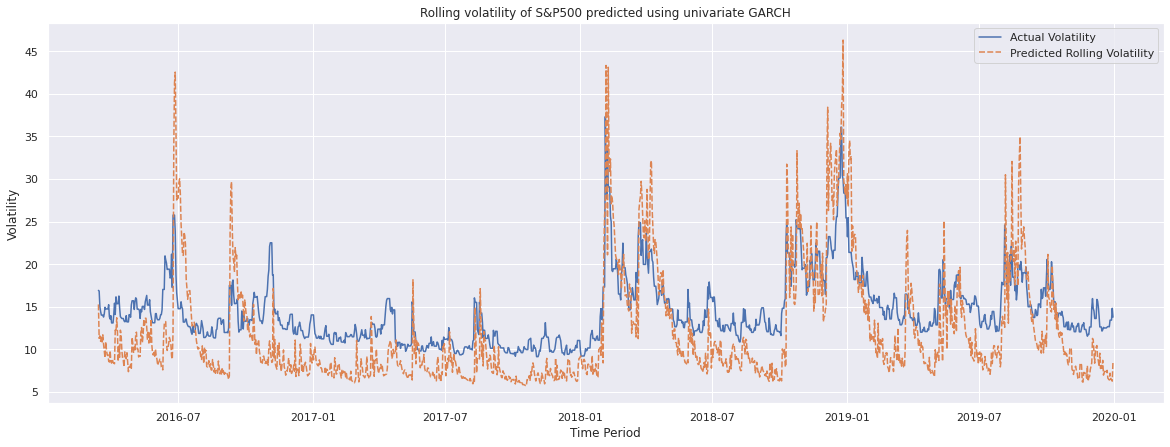

In [ ]:
df_rollingVolatility_test = pd.DataFrame(columns = ['Actual Volatility', 'Predicted Rolling Volatility'], index = df_dailyData_test.index)
df_rollingVolatility_test['Actual Volatility'] = df_Vix_test['Vix Index']
rolling_predictions = []
for i in range(n_test):
  rolling_model = arch_model(y = np.array(df_SPX['SPX Index'][:-(n_test-i)]), x = df_dailyData[:-(n_test-i)], vol = 'GARCH', p = best_p, o = best_o, q = best_q).fit(disp='off')
  prediction = rolling_model.forecast(horizon = 1)
  rolling_predictions.append(np.sqrt(prediction.variance.values[-1,:][0]))
df_rollingVolatility_test['Predicted Rolling Volatility'] = math.sqrt(252) * np.array(rolling_predictions)
fig_rolling = sns.lineplot(data = df_rollingVolatility_test)
fig_rolling.set(xlabel = 'Time Period', ylabel = 'Volatility', title = 'Rolling volatility of S&P500 predicted using univariate GARCH')

In [ ]:
forecasting_performance_measures(df_rollingVolatility_test['Actual Volatility'][:-1], df_rollingVolatility_test['Predicted Rolling Volatility'][:-1])

,MAE,MAPE,MEDAE,MSE,RMSE
GARCH,4.101044,29.073409,3.846404,23.050297,4.801072


In [ ]:
forecast_all_test_set = best_model.forecast(horizon = len(df_SPX_test), start = df_dailyData_test.index)

In [ ]:
df_volatility_all_test = pd.DataFrame(columns = ['Actual Volatility', 'Predicted Volatility'], index = df_dailyData_test.index)
df_volatility_all_test['Actual Volatility'] = df_Vix_test['Vix Index']
df_volatility_all_test['Predicted Volatility'] = math.sqrt(252) * np.sqrt(forecast_all_test_set.variance.values[-1,:])

In [ ]:
trends_window_SPX = 12
last_week_mean_SPX = df_Vix_train['Vix Index'][-trends_window_SPX:].mean()
df_trends_test = pd.DataFrame()
df_trends_test['Actual Volatility Trends Average'] = trends_model_average(df_volatility_all_test['Actual Volatility'], trends_window_SPX, last_week_mean_SPX)
df_trends_test['Predicted Volatility Trends Average'] = trends_model_average(df_volatility_all_test['Predicted Volatility'], trends_window_SPX, last_week_mean_SPX)
df_trends_test['Actual Volatility Trends Difference'] = trends_model_difference(df_volatility_all_test['Actual Volatility'], trends_window_SPX)
df_trends_test['Predicted Volatility Trends Difference'] = trends_model_difference(df_volatility_all_test['Predicted Volatility'], trends_window_SPX)

In [ ]:
df_metrics_average = metrics_classification_report(df_trends_test['Actual Volatility Trends Average'], df_trends_test['Predicted Volatility Trends Average'], 'Average')
df_metrics_difference = metrics_classification_report(df_trends_test['Actual Volatility Trends Difference'], df_trends_test['Predicted Volatility Trends Difference'], 'Difference')
df_metrics_report = df_metrics_average.join(df_metrics_difference)
df_metrics_report

,Average,Difference
Accuracy,0.465517,0.482759
F1,0.630952,0.647059
Precision,0.46087,0.478261
Recall,1,1


#### iii. The study with S&P500 closing price

In [ ]:
# Train/test split of our data
df_dailyData_closing_price = df_daily_data.iloc[1:].copy()
df_Vix_closing_price = df_Vix.iloc[1:].copy()
df_closing_price_stationnary = df_closing_price.iloc[1:].copy()
n_train_closing_price = int(0.8*len(df_dailyData_closing_price))
n_test_closing_price = len(df_dailyData_closing_price) - n_train_closing_price
df_dailyData_train_closing_price, df_dailyData_test_closing_price = df_dailyData_closing_price.iloc[:n_train_closing_price,:].copy(), df_dailyData_closing_price.iloc[n_train_closing_price:,:].copy()
df_Vix_train_closing_price, df_Vix_test_closing_price = df_Vix_closing_price.iloc[:n_train_closing_price,:], df_Vix_closing_price.iloc[n_train_closing_price:,:]
df_closing_price_train, df_closing_price_test = df_closing_price_stationnary.iloc[:n_train_closing_price,:].copy(), df_closing_price_stationnary.iloc[n_train_closing_price:,:].copy()

In [ ]:
dict_daily_data = {}
for column in df_dailyData_closing_price.columns:
  dict_daily_data[column] = df_dailyData_closing_price[column].values

In [ ]:
best_aic_closing_price, best_order_closing_price, best_model_closing_price = get_best_model(df_closing_price_train['Stationnary Closing Price'], dict_daily_data)

/usr/local/lib/python3.7/dist-packages/arch/univariate/base.py:752: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


AIC of best model : 29813.48030 | Order of best model : (0, 2, 2)


In [ ]:
best_p_closing_price, best_o_closing_price, best_q_closing_price = best_order_closing_price[0], best_order_closing_price[1], best_order_closing_price[2]
print(best_model_closing_price.summary())

                   Constant Mean - GJR-GARCH Model Results                    
Dep. Variable:                      y   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                  GJR-GARCH   Log-Likelihood:               -14900.7
Distribution:                  Normal   AIC:                           29813.5
Method:            Maximum Likelihood   BIC:                           29851.0
                                        No. Observations:                 3819
Date:                Sat, May 22 2021   Df Residuals:                     3818
Time:                        10:17:21   Df Model:                            1
                               Mean Model                               
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu             0.2326      0.170      1.368      0.171 [ -0.101,  0.56

[Text(0, 0.5, 'Residuals'),
 Text(0.5, 0, 'Time Period'),
 Text(0.5, 1.0, 'Standard Residuals')]

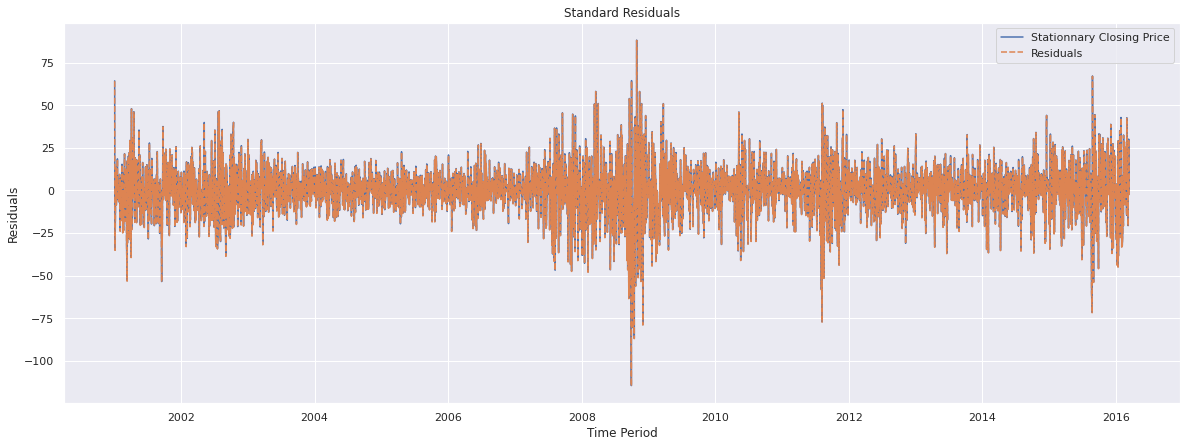

In [ ]:
df_residuals_closing_price = pd.DataFrame(columns = ['Stationnary Closing Price', 'Residuals'], index = df_dailyData_train_closing_price.index)
df_residuals_closing_price['Stationnary Closing Price'] = df_closing_price_train['Stationnary Closing Price'].copy()
df_residuals_closing_price['Residuals'] = best_model_closing_price.resid
fig = sns.lineplot(data = df_residuals_closing_price)
fig.set(xlabel = 'Time Period', ylabel = 'Residuals', title = 'Standard Residuals')

[Text(0, 0.5, 'Volatility'),
 Text(0.5, 0, 'Time Period'),
 Text(0.5, 1.0, 'Volatility of S&P500 closing price computed using univariate GARCH')]

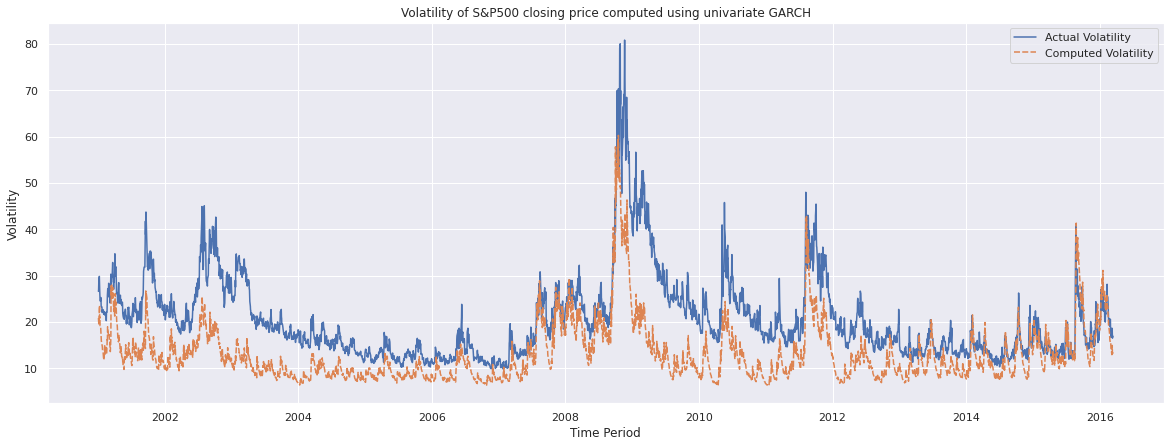

In [ ]:
conditionnalVolatility_closing_price = best_model_closing_price.conditional_volatility
df_volatility_train_closing_price = pd.DataFrame(columns = ['Actual Volatility', 'Computed Volatility'], index = df_dailyData_train_closing_price.index)
df_volatility_train_closing_price['Actual Volatility'] = df_Vix_train_closing_price['Vix Index']
df_volatility_train_closing_price['Computed Volatility'] = conditionnalVolatility_closing_price
fig = sns.lineplot(data = df_volatility_train_closing_price)
fig.set(xlabel = 'Time Period', ylabel = 'Volatility', title = 'Volatility of S&P500 closing price computed using univariate GARCH')

In [ ]:
n_days_closing_price = 3
forecast_closing_price = best_model_closing_price.forecast(horizon = n_days_closing_price)
forecast_closing_price.variance.tail()

,h.1,h.2,h.3
3814,NaN,NaN,NaN
3815,NaN,NaN,NaN
3816,NaN,NaN,NaN
3817,NaN,NaN,NaN
3818,151.845786,159.017745,153.844416


[Text(0, 0.5, 'Volatility'),
 Text(0.5, 0, 'Time Period'),
 Text(0.5, 1.0, 'Volatility of S&P500 predicted using univariate GARCH')]

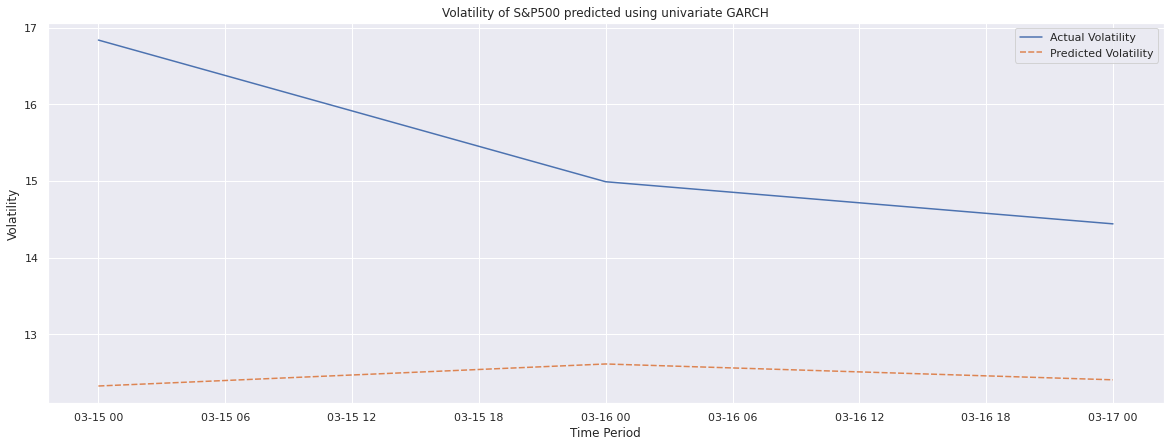

In [ ]:
df_volatility_test_closing_price = pd.DataFrame(columns = ['Actual Volatility', 'Predicted Volatility'], index = df_dailyData_test_closing_price.index[0 : n_days_closing_price])
df_volatility_test_closing_price['Actual Volatility'] = df_Vix_test_closing_price['Vix Index'][: n_days_closing_price ]
df_volatility_test_closing_price['Predicted Volatility'] = np.sqrt(forecast_closing_price.variance.values[-1,:])
fig = sns.lineplot(data = df_volatility_test_closing_price)
fig.set(xlabel='Time Period', ylabel = 'Volatility', title = 'Volatility of S&P500 predicted using univariate GARCH')

In [ ]:
forecasting_performance_measures(df_volatility_test_closing_price['Actual Volatility'], df_volatility_test_closing_price['Predicted Volatility'])

,MAE,MAPE,MEDAE,MSE,RMSE
GARCH,2.977934,18.935064,2.379776,10.072738,3.173758


In [ ]:
df_volatility_test_closing_price_mma = pd.DataFrame(columns = ['Actual Volatility', 'Predicted Volatility'], index = df_dailyData_test.index[0 : n_days_closing_price])
trends_window_1_closing_price_mma = 3
trends_window_2_closing_price_mma = 5
df_volatility_test_closing_price_mma['Actual Volatility'] = df_Vix_test['Vix Index'][0 : n_days_closing_price]
df_volatility_test_closing_price_mma['Predicted Volatility'] = math.sqrt(252) * np.sqrt(forecast_closing_price.variance.values[-1,:])
df_volatility_test_closing_price_mma['MMA-' + str(trends_window_1_closing_price_mma) + ' Actual Volatility'] = pd.DataFrame(data = mma(df_volatility_test_closing_price_mma['Actual Volatility'].copy(), trends_window_1_closing_price_mma), index = df_dailyData_test.index[0 : n_days_closing_price])
df_volatility_test_closing_price_mma['MMA-' + str(trends_window_2_closing_price_mma) + ' Actual Volatility'] = pd.DataFrame(data = mma(df_volatility_test_closing_price_mma['Actual Volatility'].copy(), trends_window_2_closing_price_mma), index = df_dailyData_test.index[0 : n_days_closing_price])
df_volatility_test_closing_price_mma['MMA-' + str(trends_window_1_closing_price_mma) + ' Predicted Volatility'] = pd.DataFrame(data = mma(df_volatility_test_closing_price_mma['Predicted Volatility'].copy(), trends_window_1_closing_price_mma), index = df_dailyData_test.index[0 : n_days_closing_price])
df_volatility_test_closing_price_mma['MMA-' + str(trends_window_2_closing_price_mma) + ' Predicted Volatility'] = pd.DataFrame(data = mma(df_volatility_test_closing_price_mma['Predicted Volatility'].copy(), trends_window_2_closing_price_mma), index = df_dailyData_test.index[0 : n_days_closing_price])

In [ ]:
fig, axes = plt.subplots(2,1)
sns.lineplot(x = df_volatility_test_closing_price_mma.index, y = df_volatility_test_closing_price_mma['Actual Volatility'], ax = axes[0], legend = 'auto')
sns.lineplot(x = df_volatility_test_closing_price_mma.index, y = df_volatility_test_closing_price_mma['MMA-' + str(trends_window_1_closing_price_mma) + ' Actual Volatility'], ax = axes[0], legend = 'auto')
sns.lineplot(x = df_volatility_test_closing_price_mma.index, y = df_volatility_test_closing_price_mma['MMA-' + str(trends_window_2_closing_price_mma) + ' Actual Volatility'], ax = axes[0], legend = 'auto')
axes[0].legend(labels = ['Actual Volatility', 'MMA-' + str(trends_window_1_closing_price_mma) + ' Actual Volatility', 'MMA-' + str(trends_window_2_closing_price_mma) + ' Actual Volatility'])
axes[0].set(xlabel = 'Time Period', ylabel = 'Volatility')
sns.lineplot(x = df_volatility_test_closing_price_mma.index, y = df_volatility_test_closing_price_mma['Predicted Volatility'], ax = axes[1], legend = 'auto')
sns.lineplot(x = df_volatility_test_closing_price_mma.index, y = df_volatility_test_closing_price_mma['MMA-' + str(trends_window_1_mma) + ' Predicted Volatility'], ax = axes[1], legend = 'auto')
sns.lineplot(x = df_volatility_test_closing_price_mma.index, y = df_volatility_test_closing_price_mma['MMA-' + str(trends_window_2_closing_price_mma) + ' Predicted Volatility'], ax = axes[1], legend = 'auto')
axes[1].legend(labels = ['Predicted Volatility', 'MMA-' + str(trends_window_1_closing_price_mma) + ' Predicted Volatility', 'MMA-' + str(trends_window_2_closing_price_mma) + ' Predicted Volatility'])
axes[1].set(xlabel = 'Time Period', ylabel = 'Volatility')

In [ ]:
df_volatility_test_closing_price_mme = pd.DataFrame(columns = ['Actual Volatility', 'Predicted Volatility'], index = df_dailyData_test.index[0 : n_days_closing_price])
trends_window_1_closing_price_mme = 3
trends_window_2_closing_price_mme = 8
df_volatility_test_closing_price_mme['Actual Volatility'] = df_Vix_test['Vix Index'][0 : n_days_closing_price]
df_volatility_test_closing_price_mme['Predicted Volatility'] = math.sqrt(252) * np.sqrt(forecast_closing_price.variance.values[-1,:])
df_volatility_test_closing_price_mme['MME-' + str(trends_window_1_closing_price_mme) + ' Actual Volatility'] = pd.DataFrame(data = mme(df_volatility_test_closing_price_mme['Actual Volatility'].copy(), trends_window_1_closing_price_mme), index = df_dailyData_test.index[0 : n_days_closing_price])
df_volatility_test_closing_price_mme['MME-' + str(trends_window_2_closing_price_mme) + ' Actual Volatility'] = pd.DataFrame(data = mme(df_volatility_test_closing_price_mme['Actual Volatility'].copy(), trends_window_2_closing_price_mme), index = df_dailyData_test.index[0 : n_days_closing_price])
df_volatility_test_closing_price_mme['MME-' + str(trends_window_1_closing_price_mme) + ' Predicted Volatility'] = pd.DataFrame(data = mme(df_volatility_test_closing_price_mme['Predicted Volatility'].copy(), trends_window_1_closing_price_mme), index = df_dailyData_test.index[0 : n_days_closing_price])
df_volatility_test_closing_price_mme['MME-' + str(trends_window_2_closing_price_mme) + ' Predicted Volatility'] = pd.DataFrame(data = mme(df_volatility_test_closing_price_mme['Predicted Volatility'].copy(), trends_window_2_closing_price_mme), index = df_dailyData_test.index[0 : n_days_closing_price])

In [ ]:
fig, axes = plt.subplots(2,1)
sns.lineplot(x = df_volatility_test_closing_price_mme.index, y = df_volatility_test_closing_price_mme['Actual Volatility'], ax = axes[0], legend = 'auto')
sns.lineplot(x = df_volatility_test_closing_price_mme.index, y = df_volatility_test_closing_price_mme['MME-' + str(trends_window_1_closing_price_mme) + ' Actual Volatility'], ax = axes[0], legend = 'auto')
sns.lineplot(x = df_volatility_test_closing_price_mme.index, y = df_volatility_test_closing_price_mme['MME-' + str(trends_window_2_closing_price_mme) + ' Actual Volatility'], ax = axes[0], legend = 'auto')
axes[0].legend(labels = ['Actual Volatility', 'MME-' + str(trends_window_1_closing_price_mme) + ' Actual Volatility', 'MMA-' + str(trends_window_2_closing_price_mme) + ' Actual Volatility'])
axes[0].set(xlabel = 'Time Period', ylabel = 'Volatility')
sns.lineplot(x = df_volatility_test_closing_price_mme.index, y = df_volatility_test_closing_price_mme['Predicted Volatility'], ax = axes[1], legend = 'auto')
sns.lineplot(x = df_volatility_test_closing_price_mme.index, y = df_volatility_test_closing_price_mme['MME-' + str(trends_window_1_closing_price_mme) + ' Predicted Volatility'], ax = axes[1], legend = 'auto')
sns.lineplot(x = df_volatility_test_closing_price_mme.index, y = df_volatility_test_closing_price_mme['MME-' + str(trends_window_2_closing_price_mme) + ' Predicted Volatility'], ax = axes[1], legend = 'auto')
axes[1].legend(labels = ['Predicted Volatility', 'MME-' + str(trends_window_1_closing_price_mme) + ' Predicted Volatility', 'MME-' + str(trends_window_2_closing_price_mme) + ' Predicted Volatility'])
axes[1].set(xlabel = 'Time Period', ylabel = 'Volatility')

[Text(0, 0.5, 'Volatility'),
 Text(0.5, 0, 'Time Period'),
 Text(0.5, 1.0, 'Rolling volatility of S&P500 predicted using univariate GARCH')]

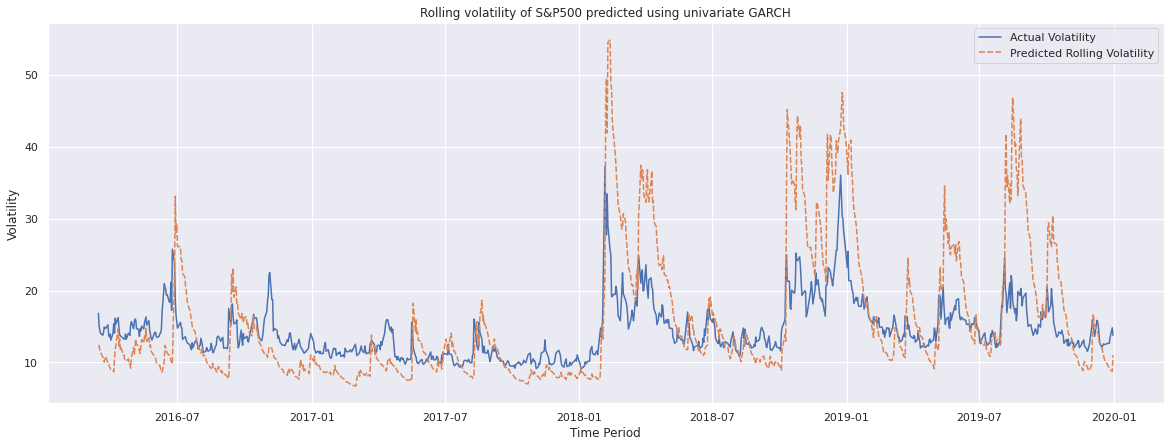

In [ ]:
df_rollingVolatility_test_closing_price = pd.DataFrame(columns = ['Actual Volatility', 'Predicted Rolling Volatility'], index = df_dailyData_test_closing_price.index)
df_rollingVolatility_test_closing_price['Actual Volatility'] = df_Vix_test_closing_price['Vix Index']
rolling_predictions_closing_price = []
for i in range(n_test_closing_price):
  rolling_model_closing_price = arch_model(y = np.array(df_closing_price_stationnary['Stationnary Closing Price'][:-(n_test_closing_price-i)]), x = df_dailyData[1:-(n_test_closing_price-i)], vol = 'GARCH', p = best_p_closing_price, o = best_o_closing_price, q = best_q_closing_price).fit(disp='off')
  prediction_closing_price = rolling_model_closing_price.forecast(horizon = 1)
  rolling_predictions_closing_price.append(np.sqrt(prediction_closing_price.variance.values[-1,:][0]))
df_rollingVolatility_test_closing_price['Predicted Rolling Volatility'] = np.array(rolling_predictions_closing_price)
fig_rolling = sns.lineplot(data = df_rollingVolatility_test_closing_price)
fig_rolling.set(xlabel = 'Time Period', ylabel = 'Volatility', title = 'Rolling volatility of S&P500 predicted using univariate GARCH')

In [ ]:
forecasting_performance_measures(df_rollingVolatility_test_closing_price['Actual Volatility'][:-1], df_rollingVolatility_test_closing_price['Predicted Rolling Volatility'][:-1])

,MAE,MAPE,MEDAE,MSE,RMSE
GARCH,4.658431,29.081371,2.943814,47.145374,6.866249


In [ ]:
trends_window_1 = 3
train_last_window_1_mean = df_Vix_train_closing_price['Vix Index'][-trends_window_1:].mean()
actual_trends_volatility_window_1 = pd.DataFrame({'Average' : trends_model_average(df_Vix_test_closing_price['Vix Index'], trends_window_1, train_last_window_1_mean), 'Difference' : trends_model_difference(df_Vix_test_closing_price['Vix Index'], trends_window_1)})
predicted_trends_volatility_window_1 = pd.DataFrame(trends_forecast(best_o_closing_price, best_p_closing_price, best_q_closing_price, df_dailyData_closing_price, df_closing_price_stationnary['Stationnary Closing Price'], df_Vix_closing_price['Vix Index'], n_test_closing_price, n_train_closing_price, trends_window_1))
df_metrics_closing_price_average_window_1 = metrics_classification_report(actual_trends_volatility_window_1['Average'], predicted_trends_volatility_window_1['Average'], 'Average-' + str(trends_window_1))
df_metrics_closing_price_difference_window_1 = metrics_classification_report(actual_trends_volatility_window_1['Difference'], predicted_trends_volatility_window_1['Difference'], 'Difference-' + str(trends_window_1))
df_metrics_report_closing_price_window_1 = df_metrics_closing_price_average_window_1.join(df_metrics_closing_price_difference_window_1)

In [ ]:
df_metrics_report_closing_price_window_1

,Average-3,Difference-3
Accuracy,0.545455,0.526646
F1,0.52459,0.597333
Precision,0.519481,0.5
Recall,0.529801,0.741722


In [ ]:
confusion_matrix_window_1_average = confusion_matrix(actual_trends_volatility_window_1['Average'], predicted_trends_volatility_window_1['Average'])
confusion_matrix_window_1_average

,Actual Positive,Actual Negative
Predicted Positive,94,74
Predicted Negative,71,80


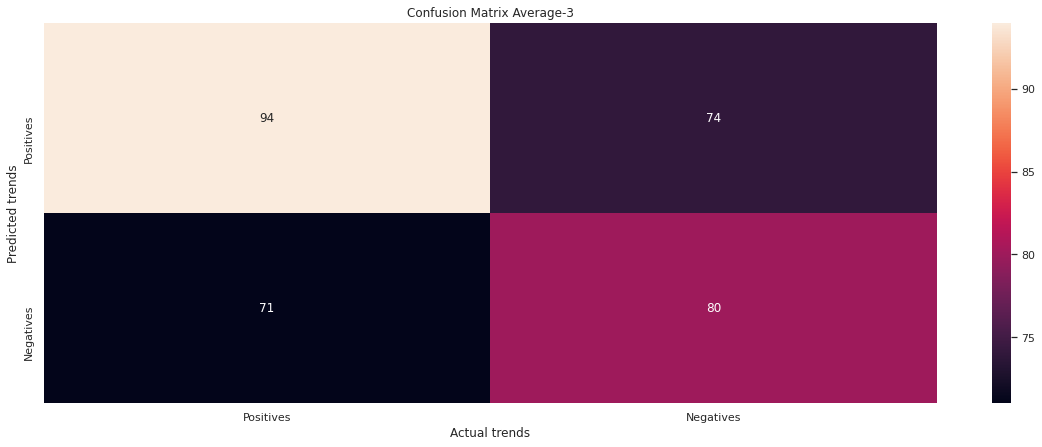

In [ ]:
plot_confusion_matrix(confusion_matrix_window_1_average, 'Average', trends_window_1)

In [ ]:
confusion_matrix_window_1_difference = confusion_matrix(actual_trends_volatility_window_1['Difference'], predicted_trends_volatility_window_1['Difference'])
confusion_matrix_window_1_difference

,Actual Positive,Actual Negative
Predicted Positive,56,112
Predicted Negative,39,112


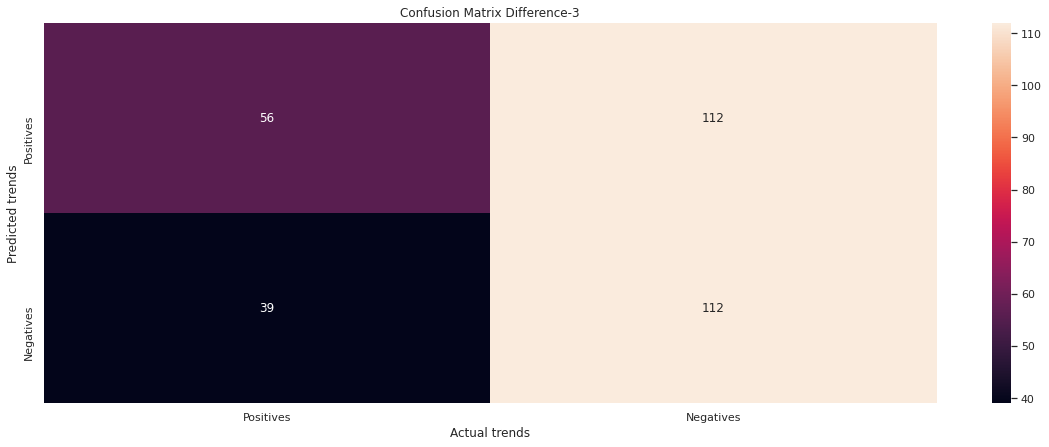

In [ ]:
plot_confusion_matrix(confusion_matrix_window_1_difference, 'Difference', trends_window_1)

[Text(0, 0.5, 'TVP'), Text(0.5, 0, 'TFP')]

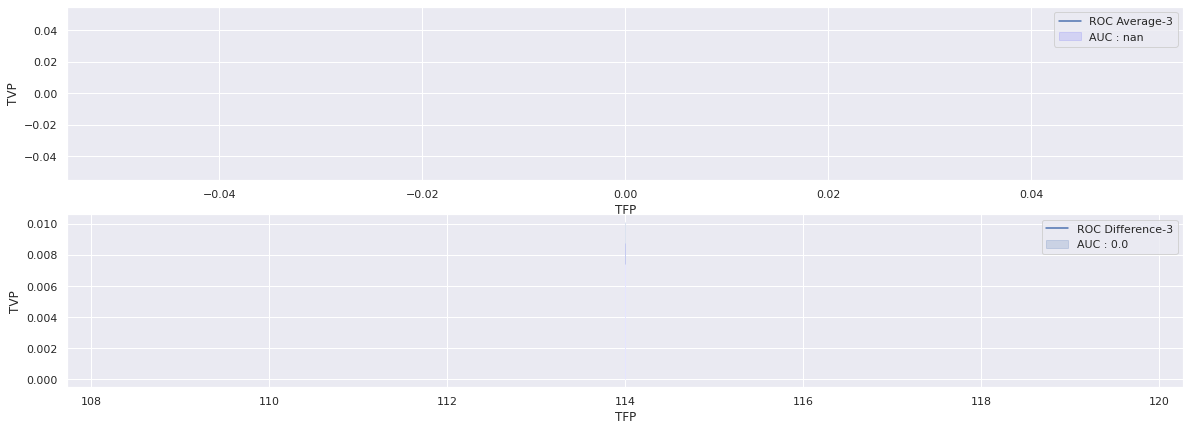

In [ ]:
df_roc_trends_window_1 = pd.DataFrame()
df_roc_trends_window_1['TFP Average'], df_roc_trends_window_1['TVP Average'] = roc(actual_trends_volatility_window_1['Average'], predicted_trends_volatility_window_1['Average'])
df_roc_trends_window_1['TFP Difference'], df_roc_trends_window_1['TVP Difference'] = roc(actual_trends_volatility_window_1['Difference'], predicted_trends_volatility_window_1['Difference'])
fig, axes = plt.subplots(2,1)
ax_0 = sns.lineplot(x = df_roc_trends_window_1['TFP Average'], y = df_roc_trends_window_1['TVP Average'], ax = axes[0])
ax_0.fill_between(ax_0.lines[0].get_xydata()[:,0] , ax_0.lines[0].get_xydata()[:,1], color = "blue", alpha = 0.1)
axes[0].legend(labels = ['ROC Average-' + str(trends_window_1), 'AUC : ' + str(auc(df_roc_trends_window_1['TFP Average'], df_roc_trends_window_1['TVP Average']))])
axes[0].set(xlabel = 'TFP', ylabel = 'TVP')
ax_1 = sns.lineplot(x = df_roc_trends_window_1['TFP Difference'], y = df_roc_trends_window_1['TVP Difference'], ax =axes[1])
ax_1.fill_between(ax_1.lines[0].get_xydata()[:,0] , ax_1.lines[0].get_xydata()[:,1], color = "blue", alpha = 0.1)
axes[1].legend(labels = ['ROC Difference-' + str(trends_window_1), 'AUC : ' + str(auc(df_roc_trends_window_1['TFP Difference'], df_roc_trends_window_1['TVP Difference']))])
axes[1].set(xlabel = 'TFP', ylabel = 'TVP')

In [ ]:
roc(actual_trends_volatility_window_1['Average'], predicted_trends_volatility_window_1['Average'])

(      0
 0   NaN
 1   NaN
 2   NaN
 3   NaN
 4   NaN
 ..   ..
 458 NaN
 459 NaN
 460 NaN
 461 NaN
 462 NaN
 
 [463 rows x 1 columns],       0
 0   NaN
 1   NaN
 2   NaN
 3   NaN
 4   NaN
 ..   ..
 458 NaN
 459 NaN
 460 NaN
 461 NaN
 462 NaN
 
 [463 rows x 1 columns])

In [ ]:
trends_window_2 = 7
train_last_window_2_mean = df_Vix_train_closing_price['Vix Index'][-trends_window_2:].mean()
actual_trends_volatility_window_2 = {'Average' : trends_model_average(df_Vix_test_closing_price['Vix Index'], trends_window_2, train_last_window_2_mean), 'Difference' : trends_model_difference(df_Vix_test_closing_price['Vix Index'], trends_window_2)}
predicted_trends_volatility_window_2 = trends_forecast(best_o_closing_price, best_p_closing_price, best_q_closing_price, df_dailyData_closing_price, df_closing_price_stationnary['Stationnary Closing Price'], df_Vix_closing_price['Vix Index'], n_test_closing_price, n_train_closing_price, trends_window_2)
df_metrics_closing_price_average_window_2 = metrics_classification_report(actual_trends_volatility_window_2['Average'], predicted_trends_volatility_window_2['Average'], 'Average-' + str(trends_window_2))
df_metrics_closing_price_difference_window_2 = metrics_classification_report(actual_trends_volatility_window_2['Difference'], predicted_trends_volatility_window_2['Difference'], 'Difference-' + str(trends_window_2))
df_metrics_report_closing_price_window_2 = df_metrics_closing_price_average_window_2.join(df_metrics_closing_price_difference_window_2)

In [ ]:
df_metrics_report_closing_price_window_2

,Average-7,Difference-7
Accuracy,0.422111,0.582915
F1,0.311377,0.484472
Precision,0.356164,0.46988
Recall,0.276596,0.5


In [ ]:
confusion_matrix(actual_trends_volatility_window_2['Average'], predicted_trends_volatility_window_2['Average'])

,Actual Positive,Actual Negative
Predicted Positive,58,47
Predicted Negative,68,26


In [ ]:
confusion_matrix(actual_trends_volatility_window_2['Difference'], predicted_trends_volatility_window_2['Difference'])

,Actual Positive,Actual Negative
Predicted Positive,77,44
Predicted Negative,39,39


In [ ]:
df_roc_trends_window_2 = pd.DataFrame()
df_roc_trends_window_2['TFP Average'], df_roc_trends_window_2['TVP Average'] = roc(predicted_trends_volatility_window_2['Average'])
df_roc_trends_window_2['TFP Difference'], df_roc_trends_window_2['TVP Difference'] = roc(predicted_trends_volatility_window_2['Difference'])
fig, axes = plt.subplots(2,1)
ax_0 = sns.lineplot(x = df_roc_trends_window_2['TFP Average'], y = df_roc_trends_window_2['TVP Average'], ax = axes[0])
ax_0.fill_between(ax_0.lines[0].get_xydata()[:,0] , ax_0.lines[0].get_xydata()[:,1], color = "blue", alpha = 0.1)
axes[0].legend(labels = ['ROC Average-' + str(trends_window_2), 'AUC : ' + str(auc(df_roc_trends_window_2['TFP Average'], df_roc_trends_window_2['TVP Average']))])
axes[0].set(xlabel = 'TFP' , ylabel = 'TVP')
ax_1 = sns.lineplot(x = df_roc_trends_window_2['TFP Difference'], y = df_roc_trends_window_2['TVP Difference'], ax =axes[1])
ax_1.fill_between(ax_1.lines[0].get_xydata()[:,0] , ax_1.lines[0].get_xydata()[:,1], color = "blue", alpha = 0.1)
axes[1].legend(labels = ['ROC Difference-' + str(trends_window_2), 'AUC : ' + str(auc(df_roc_trends_window_2['TFP Difference'], df_roc_trends_window_2['TVP Difference']))])
axes[1].set(xlabel = 'TFP', ylabel = 'TVP')

In [ ]:
trends_window_3 = 12
train_last_window_3_mean = df_Vix_train_closing_price['Vix Index'][-trends_window_3:].mean()
actual_trends_volatility_window_3 = {'Average' : trends_model_average(df_Vix_test_closing_price['Vix Index'], trends_window_3, train_last_window_3_mean), 'Difference' : trends_model_difference(df_Vix_test_closing_price['Vix Index'], trends_window_3)}
predicted_trends_volatility_window_3 = trends_forecast(best_o_closing_price, best_p_closing_price, best_q_closing_price, df_dailyData_closing_price, df_closing_price_stationnary['Stationnary Closing Price'], df_Vix_closing_price['Vix Index'], n_test_closing_price, n_train_closing_price, trends_window_3)
df_metrics_closing_price_average_window_3 = metrics_classification_report(actual_trends_volatility_window_3['Average'], predicted_trends_volatility_window_3['Average'], 'Average-' + str(trends_window_3))
df_metrics_closing_price_difference_window_3 = metrics_classification_report(actual_trends_volatility_window_3['Difference'], predicted_trends_volatility_window_3['Difference'], 'Difference-' + str(trends_window_3))
df_metrics_report_closing_price_window_3 = df_metrics_closing_price_average_window_3.join(df_metrics_closing_price_difference_window_3)

In [ ]:
confusion_matrix(actual_trends_volatility_window_3['Average'], predicted_trends_volatility_window_3['Average'])

,Actual Positive,Actual Negative
Predicted Positive,36,27
Predicted Negative,25,28


In [ ]:
confusion_matrix(actual_trends_volatility_window_3['Difference'], predicted_trends_volatility_window_3['Difference'])

,Actual Positive,Actual Negative
Predicted Positive,45,16
Predicted Negative,29,26


In [ ]:
df_roc_trends_window_3 = pd.DataFrame()
df_roc_trends_window_3['TFP Average'], df_roc_trends_window_3['TVP Average'] = roc(predicted_trends_volatility_window_3['Average'])
df_roc_trends_window_3['TFP Difference'], df_roc_trends_window_3['TVP Difference'] = roc(predicted_trends_volatility_window_3['Difference'])
fig, axes = plt.subplots(2,1)
ax_0 = sns.lineplot(x = df_roc_trends_window_3['TFP Average'], y = df_roc_trends_window_3['TVP Average'], ax =axes[0])
ax_0.fill_between(ax_0.lines[0].get_xydata()[:,0] , ax_0.lines[0].get_xydata()[:,1], color = "blue", alpha = 0.1)
axes[0].legend(labels = ['ROC Average-' + str(trends_window_3), 'AUC : ' + str(auc(df_roc_trends_window_3['TFP Average'], df_roc_trends_window_3['TVP Average']))])
axes[0].set(xlabel = None, ylabel = 'TVP')
ax_1 = sns.lineplot(x = df_roc_trends_window_3['TFP Difference'], y = df_roc_trends_window_3['TVP Difference'], ax =axes[1])
ax_1.fill_between(ax_1.lines[0].get_xydata()[:,0] , ax_1.lines[0].get_xydata()[:,1], color = "blue", alpha = 0.1)
axes[1].legend(labels = ['ROC Difference-' + str(trends_window_3), 'AUC : ' + str(auc(df_roc_trends_window_3['TFP Difference'], df_roc_trends_window_3['TVP Difference']))])
axes[1].set(xlabel = 'TFP', ylabel = 'TVP')

### c. A step back on S&P500 : an unpredictable white noise



##### i. Wavelets denoising process

In [ ]:
def get_order_wavelet(family, wavelet):
  if len(family) == len(wavelet):
    return 1
  else :
    return float(wavelet[len(family):])

In [ ]:
def get_maximum_level_wavelet(df):
  return math.ceil(np.log2(1.5*len(df)))

In [ ]:
def get_best_wavelet(df):
  best_SNR, mode_best_SNR, scale_best_SNR, wavelet_best_SNR = -np.inf, None, None, None
  best_RMSE, mode_best_RMSE, scale_best_RMSE, wavelet_best_RMSE = np.inf, None, None, None
  families = pywt.families(short = True)[:4]
  modes = pywt.Modes.modes
  threshold_modes = ['garrote', 'soft']
  scales = [i/100 for i in range(5, 30, 5)]
  maximum_level = get_maximum_level_wavelet(df)
  for family in families :
    subfamilies = pywt.wavelist(family)
    for wavelet in subfamilies :
      if get_order_wavelet(family, wavelet) <= maximum_level :
        for i, scale in enumerate(scales):
          for m in modes :
            for threshold_m in threshold_modes :
              coefficients = pywt.wavedec(df, wavelet, mode = m)
              coefficients[1:] = [pywt.threshold(i, value = scale * df.max(), mode = threshold_m) for i in coefficients[1:]]
              reconstructed = pywt.waverec(coefficients, wavelet, mode = m)
              snr = 10 * math.log(sum(reconstructed**2)/sum((df - reconstructed)**2))
              rmse = math.sqrt(metrics.mean_squared_error(df, reconstructed))
              if snr > best_SNR :
                best_SNR, mode_best_SNR, threshold_best_mode_SNR, scale_best_SNR, wavelet_best_SNR, RMSE_best_SNR = snr, m, threshold_m, scale, wavelet, rmse
              if rmse < best_RMSE :
                best_RMSE, mode_best_RMSE, threshold_best_mode_RMSE, scale_best_RMSE, wavelet_best_RMSE, SNR_best_RMSE = rmse, m, threshold_m, scale, wavelet, snr
  if (best_SNR == SNR_best_RMSE) and (best_RMSE == RMSE_best_SNR) :
    print('The best model has the best RMSE & the best SNR at the same time.')
    print('Mode of best model : {} | Threshold mode of best model : {} | Scale of best model : {} | Wavelet of best model : {}.'.format(mode_best_SNR, threshold_best_mode_SNR, scale_best_SNR, wavelet_best_SNR))
    print('SNR of best model : {:6.5f} | RMSE of best model : {:6.5f}.'.format(best_SNR, RMSE_best_SNR))
    return mode_best_SNR, threshold_best_mode_SNR, scale_best_SNR, wavelet_best_SNR
  elif (best_SNR - SNR_best_RMSE) > (best_RMSE - RMSE_best_SNR):
    print('The model with best SNR was chosen.')
    print('Mode of best model : {} | Threshold mode of best model : {} | Scale of best model : {} | Wavelet of best model : {}.'.format(mode_best_SNR, threshold_best_mode_SNR, scale_best_SNR, wavelet_best_SNR))
    print('SNR of best model : {:6.5f} | RMSE of best model : {:6.5f}.'.format(best_SNR, RMSE_best_SNR))
    return mode_best_SNR, threshold_best_mode_SNR, scale_best_SNR, wavelet_best_SNR
  else :
    print('The model with best RMSE was chosen.')
    print('Mode of best model : {} | Threshold mode of best model : {} | Scale of best model : {} | Wavelet of best model : {}.'.format(mode_best_RMSE, threshold_best_mode_RMSE, scale_best_RMSE, wavelet_best_RMSE))
    print('SNR of best model : {:6.5f} | RMSE of best model : {:6.5f}.'.format(SNR_best_RMSE, best_RMSE))
    return mode_best_RMSE, threshold_best_mode_RMSE, scale_best_RMSE, wavelet_best_RMSE

#### iii. The study with S&P500 closing price

In [ ]:
best_mode_closing_price, threshold_best_mode_closing_price, best_scale_closing_price, best_wavelet_closing_price = get_best_wavelet(df_closing_price['Closing Price'])

In [ ]:
best_coefficients_closing_price = pywt.wavedec(df_closing_price['Closing Price'], best_wavelet_closing_price, mode = best_mode_closing_price)
best_coefficients_closing_price[1:] = [pywt.threshold(i, value = best_scale_closing_price * df_closing_price['Closing Price'].max(), mode = threshold_best_mode_closing_price) for i in best_coefficients_closing_price[1:]]
best_reconstructed_closing_price = pywt.waverec(best_coefficients_closing_price, best_wavelet_closing_price, mode = best_mode_closing_price)

[Text(0.5, 0, 'Time Period'),
 Text(0.5, 1.0, 'Wavelet denoising Closing Price')]

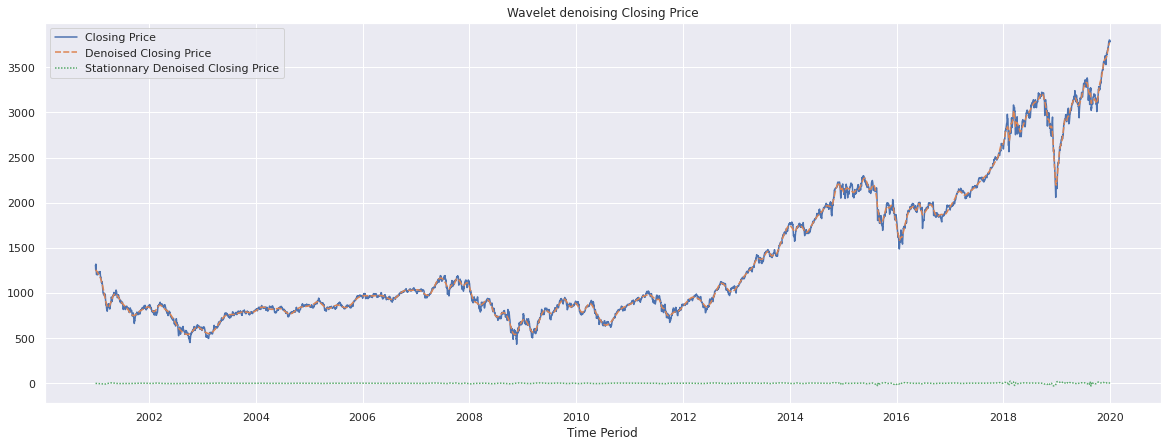

In [ ]:
df_closing_price_wavelet = pd.DataFrame(columns = ['Closing Price', 'Denoised Closing Price'], index = df_closing_price.index)
df_closing_price_wavelet['Closing Price']  = df_closing_price['Closing Price']
df_closing_price_wavelet['Denoised Closing Price'] = best_reconstructed_closing_price
df_closing_price_wavelet['Stationnary Denoised Closing Price'] = pd.DataFrame(np.diff(df_closing_price_wavelet['Denoised Closing Price']), index = df_dailyData.index[1:])
fig = sns.lineplot(data = df_closing_price_wavelet)
fig.set(xlabel='Time Period', title = 'Wavelet denoising Closing Price')

[Text(0, 0.5, 'Closing Price'),
 Text(0.5, 0, 'Time Period'),
 Text(0.5, 1.0, 'Stationnary Denoised Closing Price')]

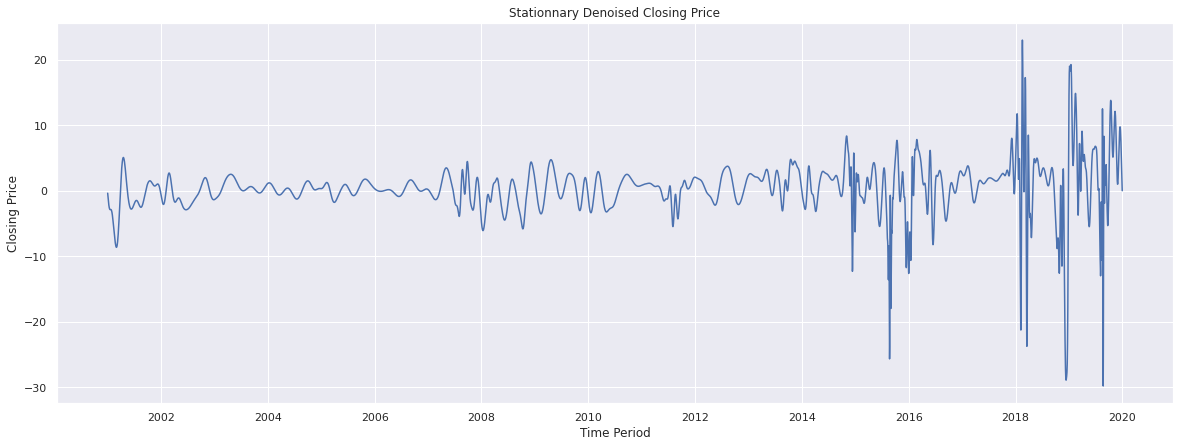

In [ ]:
fig = sns.lineplot(data = df_closing_price_wavelet['Stationnary Denoised Closing Price'])
fig.set(xlabel = 'Time Period', ylabel = 'Closing Price', title = 'Stationnary Denoised Closing Price')

In [ ]:
adf_closing_price_wavelet = adfuller(df_closing_price_wavelet['Stationnary Denoised Closing Price'][1:])
 
print('ADF Statistics : {}'.format(adf_closing_price_wavelet[0]))
print('p-value : {}'.format(adf_closing_price_wavelet[1]))
print('Critical values :')
for key, value in adf_closing_price_wavelet[4].items():
    print('\t{} : {}'.format(key, value))

ADF Statistics : -12.685431146968309
p-value : 1.1624348628376115e-23
Critical values :
	1% : -3.431297527956348
	5% : -2.861958730316874
	10% : -2.5669928862783293


In [ ]:
# Train/test split of our data
df_closing_price_stationnary_wavelet = df_closing_price_wavelet.iloc[1:]
df_closing_price_wavelet_train, df_closing_price_wavelet_test = df_closing_price_stationnary_wavelet.iloc[:n_train_closing_price,:], df_closing_price_stationnary_wavelet.iloc[n_train_closing_price:,:]

In [ ]:
best_aic_closing_price_wavelet, best_order_closing_price_wavelet, best_model_closing_price_wavelet = getBestModel(df_closing_price_wavelet_train['Stationnary Denoised Closing Price'], df_dailyData_train_closing_price, r = True)

/usr/local/lib/python3.6/dist-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,
/usr/local/lib/python3.6/dist-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,
/usr/local/lib/python3.6/dist-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,
/usr/local/lib/python3.6/dist-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  Converge

AIC of best model : 16883.96626 | Order of best model : (1, 2, 8)


In [ ]:
best_p_closing_price_wavelet, best_o_closing_price_wavelet, best_q_closing_price_wavelet = best_order_closing_price_wavelet[0], best_order_closing_price_wavelet[1], best_order_closing_price_wavelet[2]
print(best_model_closing_price_wavelet.summary())

                   Constant Mean - GJR-GARCH Model Results                    
Dep. Variable:                      y   R-squared:                      -0.000
Mean Model:             Constant Mean   Adj. R-squared:                 -0.000
Vol Model:                  GJR-GARCH   Log-Likelihood:               -8428.98
Distribution:                  Normal   AIC:                           16884.0
Method:            Maximum Likelihood   BIC:                           16970.0
                                        No. Observations:                 5551
Date:                Sat, Jan 16 2021   Df Residuals:                     5538
Time:                        10:08:35   Df Model:                           13
                               Mean Model                               
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu             0.1628  1.085e-03    150.057      0.000 [  0.161,  0.16

[Text(0, 0.5, 'Residuals'),
 Text(0.5, 0, 'Time Period'),
 Text(0.5, 1.0, 'Standard Residuals')]

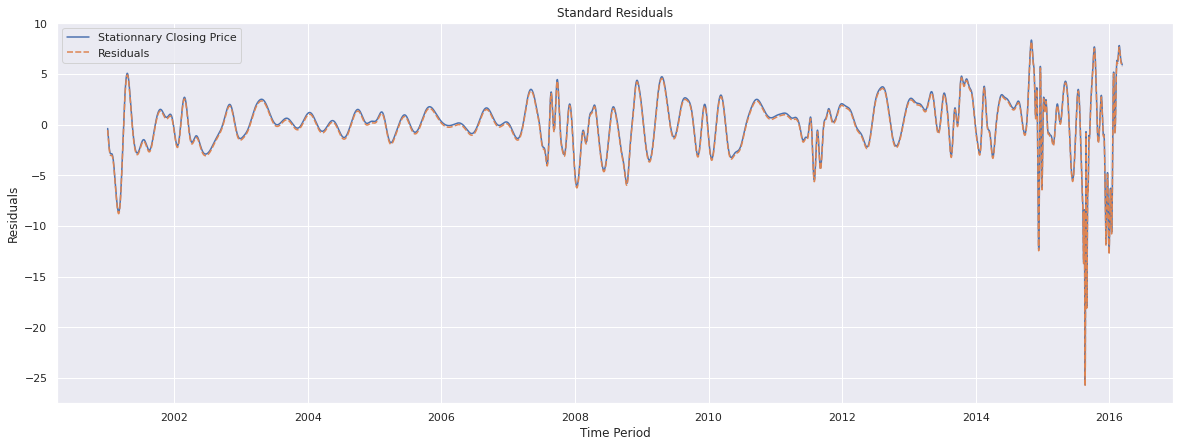

In [ ]:
df_residuals_closing_price_wavelet = pd.DataFrame(columns = ['Stationnary Closing Price', 'Residuals'], index = df_dailyData_train_closing_price.index)
df_residuals_closing_price_wavelet['Stationnary Closing Price'] = df_closing_price_wavelet_train['Stationnary Denoised Closing Price']
df_residuals_closing_price_wavelet['Residuals'] = best_model_closing_price_wavelet.resid
fig = sns.lineplot(data = df_residuals_closing_price_wavelet)
fig.set(xlabel = 'Time Period', ylabel = 'Residuals', title = 'Standard Residuals')

[Text(0, 0.5, 'Volatility'),
 Text(0.5, 0, 'Time Period'),
 Text(0.5, 1.0, 'Volatility of S&P500 closing price computed using univariate GARCH')]

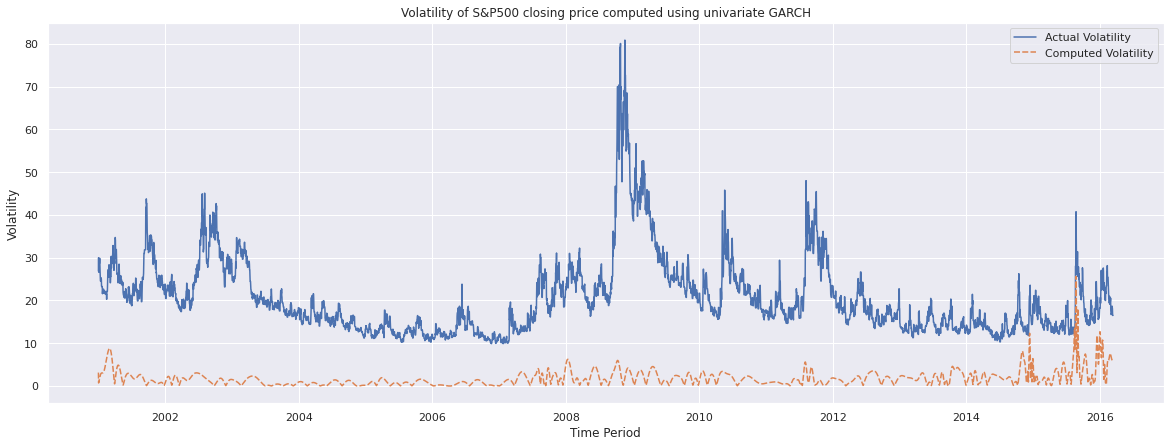

In [ ]:
conditionnalVolatility_closing_price_wavelet = best_model_closing_price_wavelet.conditional_volatility
df_volatility_train_closing_price_wavelet = pd.DataFrame(columns = ['Actual Volatility', 'Computed Volatility'], index = df_dailyData_train_closing_price.index)
df_volatility_train_closing_price_wavelet['Actual Volatility'] = df_Vix_train_closing_price['Vix Index']
df_volatility_train_closing_price_wavelet['Computed Volatility'] = conditionnalVolatility_closing_price_wavelet
fig = sns.lineplot(data = df_volatility_train_closing_price_wavelet)
fig.set(xlabel = 'Time Period', ylabel = 'Volatility', title = 'Volatility of S&P500 closing price computed using univariate GARCH')

[Text(0, 0.5, 'Volatility'),
 Text(0.5, 0, 'Time Period'),
 Text(0.5, 1.0, 'Volatility of S&P500 predicted using univariate GARCH')]

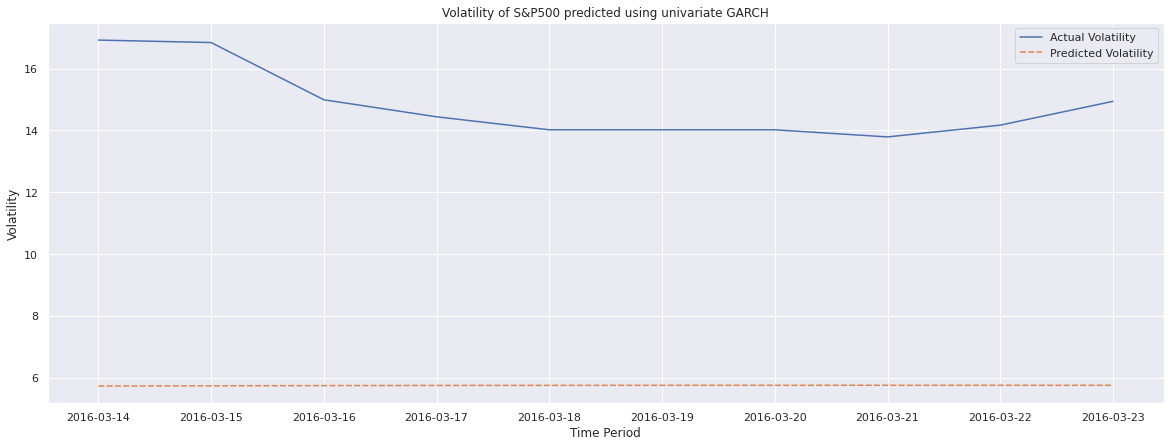

In [ ]:
n_days_closing_price_wavelet = 10
forecast_closing_price_wavelet = best_model_closing_price_wavelet.forecast(horizon = n_days_closing_price_wavelet, start = df_dailyData_train_closing_price.index)
df_volatility_test_closing_price_wavelet = pd.DataFrame(columns = ['Actual Volatility', 'Predicted Volatility'], index = df_dailyData_test_closing_price.index[0 : n_days_closing_price_wavelet])
df_volatility_test_closing_price_wavelet['Actual Volatility'] = df_Vix_test_closing_price['Vix Index'][0 : n_days_closing_price_wavelet + 1]
df_volatility_test_closing_price_wavelet['Predicted Volatility'] = np.sqrt(forecast_closing_price_wavelet.variance.values[-1,:])
fig = sns.lineplot(data = df_volatility_test_closing_price_wavelet)
fig.set(xlabel='Time Period', ylabel = 'Volatility', title = 'Volatility of S&P500 predicted using univariate GARCH')

In [ ]:
forecasting_performance_measures(df_volatility_test_closing_price_wavelet['Actual Volatility'], df_volatility_test_closing_price_wavelet['Predicted Volatility'])

In [ ]:
df_rollingVolatility_test_closing_price_wavelet = pd.DataFrame(columns = ['Actual Volatility', 'Predicted Rolling Volatility'], index = df_dailyData_test_closing_price.index)
df_rollingVolatility_test_closing_price_wavelet['Actual Volatility'] = df_dailyData_test_closing_price['Vix Index']
rolling_predictions_closing_price_wavelet = []
for i in range(n_test_closing_price):
  rolling_model_closing_price_wavelet = arch_model(y = np.array(df_closing_price_stationnary_wavelet['Stationnary Denoised Closing Price'][:-(n_test_closing_price-i)]), x = df_dailyData[1:-(n_test_closing_price-i)], vol = 'GARCH', p = best_p_closing_price_wavelet, o = best_o_closing_price_wavelet, q = best_q_closing_price_wavelet).fit(disp='off')
  prediction_closing_price_wavelet = rolling_model_closing_price_wavelet.forecast(horizon = 1)
  rolling_predictions_closing_price_wavelet.append(np.sqrt(prediction_closing_price_wavelet.variance.values[-1,:][0]))
df_rollingVolatility_test_closing_price_wavelet['Predicted Rolling Volatility'] = math.sqrt(252) * np.array(rolling_predictions_closing_price_wavelet)
fig_rolling = sns.lineplot(data = df_rollingVolatility_test_closing_price_wavelet)
fig_rolling.set(xlabel = 'Time Period', ylabel = 'Volatility', title = 'Rolling volatility of S&P500 predicted using univariate GARCH')